# Tektite model 
* The tektite dataset is compositional 
    * Compositional data is a type of data where the relative proportions of different components are important, but absolutes are not. 
    
    
* Can imagine the tektite data as the result of some end-members (N,K) propagated through a design matrix 'X' of shape (N,D). The dot product of these two matrices will result in the Data shape (N,D). 
* N - Number of observations
* D - Dimensionality of the data (i.e., The number of major oxides)


# The Dataset
* The geochemistry dataset is a matrix of shape (465, 11) 
    * The number of observations is 465
    * The number of features is 11

# Model Steps 

1) Within Model Moves
<br>
    *  Change Mixture Matrix
<br>
    *  Update Hyper-parameters
<br>
    * Sample Components

2) Between Model Moves
<br>
    * Add Component
<br>
    * Delete Component
    
    

    

# Mathematics of Compositional Data

Y = $\zeta$X + $\epsilon$

* Components
    * (F,K) 
        * F - Features of the data
        * K - Number of components
        
* Mixture
    * (N,F) 
        * N - Number of Observations
        * F - Features of the Data

In [929]:
"""
Reproducibility
and needed packages 
"""

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
import scipy.stats as stats
import numpy
from scipy.stats import poisson, dirichlet
import pickle
import os
import scipy 

np.random.seed(42) # Hitchers Guide to the Galaxy

"""
Plotting
"""
mpl.rcParams['font.size'] = 13



In [930]:
class Bayes_MT_input_data: 
    def __init__(self, filepath): 
        self.filepath = filepath
        self.Input_Data = self.load_data()
        self.Data_Features = ['K2O', 'CaO', 'TiO2', 
                              'SiO2','Al2O3', 'Na2O',
                              'MgO', 'FeO', 'MnO', 
                              'Cl', 'SO3', 'P2O5']

    def load_data(self): 
        """
        Load the data from the selected filepath
        """
        try: 
            self.Input_Data = pd.read_excel(self.filepath, skiprows = 3)
            return self.Input_Data
            print('MicroTektite Data is Loaded')
        except Exception as e: 
            print("Error Loading Data, Check file path and try again")


    def Unpack_Data_and_Features(self): 
        # Function to unpack data and 
        # clean it up to be used in a 
        # Compositional model 
        if self.Input_Data is None:
            print("No data to process")
            return None
        MT_data = self.Input_Data
        g_data =  MT_data[self.Data_Features].values
        g_data_clean = np.nan_to_num(g_data)
        Clean_Data = np.array(g_data_clean, copy = True)
        # Replace all non-positive values with 1e-11
        Clean_Data[Clean_Data <= 0] = 1e-11
        # Re-normalize everyting for consistency 
        Clean_Data /= Clean_Data.sum(axis = 1, 
                         keepdims = True)

        self.MT_Data_clean_up = Clean_Data

        return self.MT_Data_clean_up

In [931]:
MT_data_initialize = Bayes_MT_input_data('/Users/johncarter/Tektite Analysis/Bayesian Tektite Analysis/Tektites_Quant_Analyses.xlsx')

In [933]:
Clean_Data = MT_data_initialize.Unpack_Data_and_Features()

In [934]:
Clean_Data.shape

(521, 12)

In [5]:
def clr_transform(X): 
    """
    This function perform a centered log-ratio 
    transform on the dataset
    """
    clr_ = np.log(X/np.mean(X, axis = 1)[:, np.newaxis])
    
    return clr_
clr_data = clr_transform(Clean_Data)

# Prior
* Define the prior distribution for the model parameters
    * For rjMCMC this usually involves defining prior distributions for the number of components in the data

# Likelihood
* The likelihood function should calculate the probability of the observed data given the model parameters

<br>

* For compositional data the likelihood is best to be defined as a multi-nomial distribution for each parameter

<br>

* We define the likelihood function as a Dirichlet-multinomial distribution and the prior as a Dirichlet distribution for the mixture weights and a Dirichlet distribution for the components. We then implement the rjMCMC algorithm to sample from the posterior distribution.

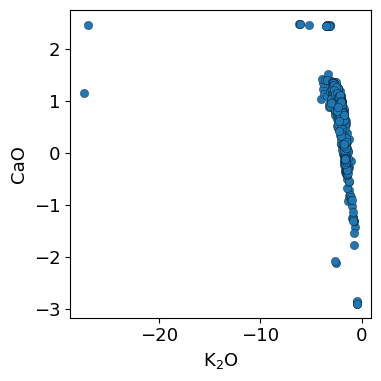

In [6]:
plt.figure(figsize = (4,4))
plt.plot(clr_data[:,0], clr_data[:,1], 'o', 
        markeredgecolor = 'k', markeredgewidth = 0.23)
plt.xlabel('K$_{2}$O')
plt.ylabel('CaO')
plt.tight_layout()


# Tektite Data
## Some added notes on tektite (impact glass) data

* Assumption is that each observed datapoint is some linear mixture of the end-members and a mixture matrix (everyting is under a sum-to-1 constraint)

* Want to estimate: 
<br>

    1) Number of End-members
    <br>

    2) Composition of End-members
   <br>

    3) Their mixture weights

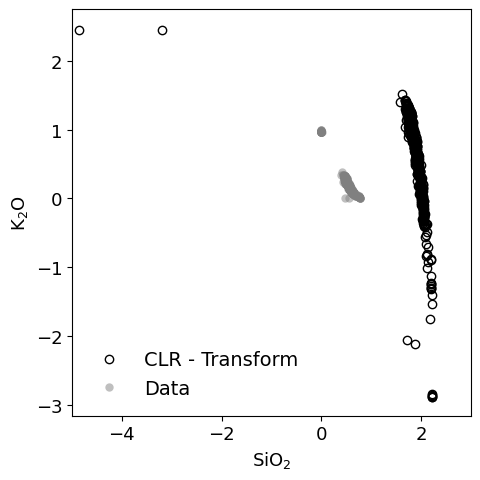

In [7]:
plt.figure(figsize= (5,5))

plt.plot(clr_data[:,3], clr_data[:,1], 'o', 
        markeredgewidth = 1, markeredgecolor = 'k', alpha = 1, 
        label = 'CLR - Transform', 
         markerfacecolor = 'None',
        color = 'k')

plt.plot(Clean_Data[:,3], Clean_Data[:,1], 'o', 
        markeredgewidth = 0, markeredgecolor = 'k', alpha = 0.5, 
        label = 'Data', 
        color = 'Grey')

plt.xlabel('SiO$_{2}$')
plt.ylabel('K$_{2}$O')
plt.legend(frameon = False, fontsize = 14)
plt.xlim(-5, 3)
plt.tight_layout()
plt.savefig('FigureS2_CLR_example.png', 
           dpi = 300, 
           bbox_inches = 'tight')



# Prior

In [8]:
def log_Prior_K(K, mu_lambda):
    """
    Combined log prior for the number of components K, using both a Poisson prior
    and an exponential penalty for K > 20.
    
    Parameters
    ----------
    K : int
        Number of components.
    lambda_poisson : float
        Parameter for the Poisson distribution in the prior of K.
    alpha : float
        Scaling factor for the exponential penalty applied to K > 20.
    
    Returns
    -------
    combined_log_prior : float
        Combined log prior incorporating both the Poisson and exponential penalties.
    """
    from scipy.stats import poisson
    
    # Poisson prior part
    log_prior = poisson.logpmf(K, 10)
    

    
    return log_prior

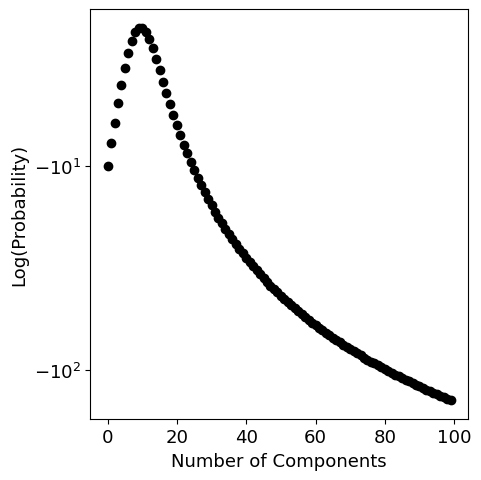

In [9]:
"""
Prior for the number of components
"""
plt.figure(figsize = (5, 5))
for i in range(100):
    plt.plot(i, 
         log_Prior_K(i, 10),
         '-o', 
         lw = 2.1, color = 'k')

plt.locator_params(axis = 'x', nbins = 10)
plt.xlabel('Number of Components')
plt.ylabel('Log(Probability)')
plt.yscale('symlog')
plt.tight_layout()
plt.savefig('FigureS3_Poisson_Prior.png', 
           dpi = 300, 
           bbox_inches = 'tight')


In [10]:
Components_guess = np.random.dirichlet(np.ones(11), 11)

In [11]:
def jacobian_birth(K):
    return np.log(p_birth / (K_max - K))

def jacobian_death(K):
    return np.log(p_death / K)

In [12]:
p_birth = 0.1
p_death = 0.1
K_max = 15
K = np.linspace(0, 15, 10).astype(int)

/var/folders/tj/5s4gb8b57v946xmbb_gqsl140000gn/T/ipykernel_2390/460347674.py:2: RuntimeWarning: divide by zero encountered in divide
  return np.log(p_birth / (K_max - K))
/var/folders/tj/5s4gb8b57v946xmbb_gqsl140000gn/T/ipykernel_2390/460347674.py:5: RuntimeWarning: divide by zero encountered in divide
  return np.log(p_death / K)


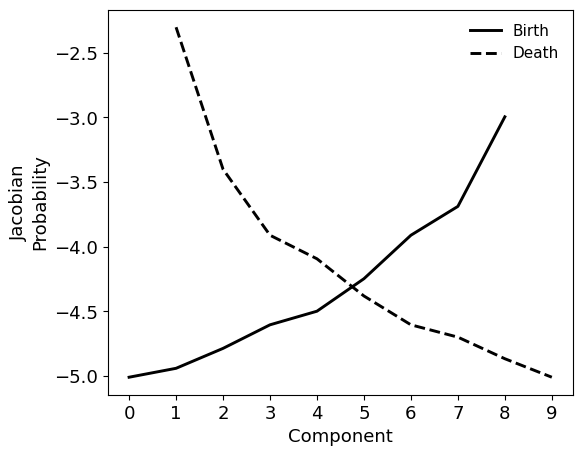

In [13]:
"""
Prior for the mixture weights
"""
plt.figure(figsize = (6, 5))
plt.plot(jacobian_birth(K), '-', 
            lw = 2.1, color = 'k', 
        label = 'Birth')

plt.plot(jacobian_death(K), '--', 
            lw = 2.1, color = 'k', 
        label = 'Death')

plt.locator_params(axis = 'x', nbins = 11)
plt.xlabel('Component');
plt.ylabel('Jacobian\nProbability');
plt.legend(frameon = False, fontsize = 11);

# The Bayesian Recipe
<br>
<br>
1) Prior, Likelihood, and Posterior
<br>
<br>
2) Acceptance Criteria
<br>
<br>
3) Proposal Function
<br>
    a) Between Model 
<br>
    b) Within Model


In [14]:
feature_labels = ['K$_{2}$O', 
                  'CaO',
                  'TiO$_{2}$', 
                  'SiO$_{2}$',
                   'Al$_{2}$O$_{3}$', 
                   'Na$_{2}$O',
                   'MgO',
                  'FeO', 
                  'MnO', 
                  'Cl', 
                  'SO$_{3}$', 
                  'P$_{2}$O$_{5}$']

# Component Dictionary     
---------

In [15]:
def generate_Granitiod_component():
    # Labels for each feature
    feature_labels = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
                      'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
                      'SO$_{3}$', 'P$_{2}$O$_{5}$']
    
    # Generating random values with given mean and standard deviation, taking absolute to avoid negative values
    values = [
            abs(np.random.normal(4.3, 2.6)),   # K$_{2}$O
            abs(np.random.normal(1.46, 2.52)), # CaO
            abs(np.random.normal(0.29, 0.25)), # TiO$_{2}$
            abs(np.random.normal(72.16, 8.05)), # SiO$_{2}$
            abs(np.random.normal(13.9, 3)),  # Al$_{2}$O$_{3}$
            abs(np.random.normal(3.6, 2)),  # Na$_{2}$O
            abs(np.random.normal(0.63, 0.1)),  # MgO
            abs(np.random.normal(1.4, 2)),   # FeO
            abs(np.random.normal(0.05, 0.01)), # MnO
            abs(np.random.normal(0.011, 0.03)),# Cl
            abs(np.random.normal(0.05, 0.42)), # SO$_{3}$
            abs(np.random.normal(0.11, 0.33)) # P$_{2}$O$_{5}$
        ]

    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    granitoid_dict = dict(zip(feature_labels, normalized_values))
    
    return granitoid_dict



In [16]:
def generate_Granitoid_component(): 
    
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
                      'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
                      'SO$_{3}$', 'P$_{2}$O$_{5}$']
    values = [
        abs(np.random.normal(4.3, 2.6)),   # K$_{2}$O
        abs(np.random.normal(1.46, 2.52)), # CaO
        abs(np.random.normal(0.29, 0.25)), # TiO$_{2}$
        abs(np.random.normal(72.16, 8.05)), # SiO$_{2}$
        abs(np.random.normal(13.9, 3)),  # Al$_{2}$O$_{3}$
        abs(np.random.normal(3.6, 2)),  # Na$_{2}$O
        abs(np.random.normal(0.63, 0.1)),  # MgO
        abs(np.random.normal(1.4, 2)),   # FeO
        abs(np.random.normal(0.05, 0.01)), # MnO
        abs(np.random.normal(0.011, 0.03)),# Cl
        abs(np.random.normal(0.05, 0.42)), # SO$_{3}$
        abs(np.random.normal(0.11, 0.33)) # P$_{2}$O$_{5}$
    ]

    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    granitoid_dict = dict(zip(Compositional_Features, normalized_values))
    
    return granitoid_dict

In [17]:
def generate_limestone_component():
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
                      'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
                      'SO$_{3}$', 'P$_{2}$O$_{5}$']   
    values = [
        abs(np.random.normal(0, 1e-6)),   # K$_{2}$O
        abs(np.random.normal(100, 3)), # CaO
        abs(np.random.normal(0, 1e-6)), # TiO$_{2}$
        abs(np.random.normal(0, 1e-6)), # SiO$_{2}$
        abs(np.random.normal(0, 1e-6)),  # Al$_{2}$O$_{3}$
        abs(np.random.normal(0, 1e-6)),  # Na$_{2}$O
        abs(np.random.normal(0, 1e-6)),  # MgO
        abs(np.random.normal(0, 1e-6)),   # FeO
        abs(np.random.normal(0, 1e-6)), # MnO
        abs(np.random.normal(0, 1e-6)),# Cl
        abs(np.random.normal(0, 1e-6)), # SO$_{3}$
        abs(np.random.normal(0, 1e-6)) # P$_{2}$O$_{5}$
    ]

    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    limestone_dict = dict(zip(Compositional_Features, normalized_values))
    
    return limestone_dict

In [18]:
def generate_Shale_component(): 
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
                  'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
                  'SO$_{3}$', 'P$_{2}$O$_{5}$']          
    values = [
        abs(np.random.normal(4, 6)),   # K$_{2}$O
        abs(np.random.normal(2.4, 1.5)), # CaO
        abs(np.random.normal(0.9, 1)), # TiO$_{2}$
        abs(np.random.normal(60, 5)), # SiO$_{2}$
        abs(np.random.normal(18.5, 6)),  # Al$_{2}$O$_{3}$
        abs(np.random.normal(1.8, 0.2)),  # Na$_{2}$O
        abs(np.random.normal(2.9, 0.5)),  # MgO
        abs(np.random.normal(7, 8)),   # FeO
        abs(np.random.normal(0.1, 0.1)), # MnO
        abs(np.random.normal(0.001, 0.001)),# Cl
        abs(np.random.normal(0.0501, 0.001)), # SO$_{3}$
        abs(np.random.normal(0.2, 0.2)) # P$_{2}$O$_{5}$
    ]

    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    shale_dict = dict(zip(Compositional_Features, normalized_values))
    
    return shale_dict     

In [19]:
def generate_Dolomite_component():     
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
              'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
              'SO$_{3}$', 'P$_{2}$O$_{5}$'] 
    values = [
        abs(np.random.normal(0, 1e-6)),   # K$_{2}$O
        abs(np.random.normal(50.95, 10)), # CaO
        abs(np.random.normal(0, 1e-6)), # TiO$_{2}$
        abs(np.random.normal(0.64, 1.3)), # SiO$_{2}$
        abs(np.random.normal(0, 1e-6)),  # Al$_{2}$O$_{3}$
        abs(np.random.normal(0, 1e-6)),  # Na$_{2}$O
        abs(np.random.normal(46.97, 10)),  # MgO
        abs(np.random.normal(1.12, 2.12)),   # FeO
        abs(np.random.normal(0, 1e-6)), # MnO
        abs(np.random.normal(0, 1e-6)),# Cl
        abs(np.random.normal(0, 1e-6)), # SO$_{3}$
        abs(np.random.normal(0, 1e-6)) # P$_{2}$O$_{5}$
    ]

    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    dolomite_dict = dict(zip(Compositional_Features, normalized_values))
    
    return dolomite_dict

In [20]:
def generate_Anhydrite_component(): 
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
          'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
          'SO$_{3}$', 'P$_{2}$O$_{5}$'] 
    # Generating random values with given mean and standard deviation
    values = [
        abs(np.random.normal(0, 1e-6)),   # K$_{2}$O
        abs(np.random.normal(40.14, 10)), # CaO
        abs(np.random.normal(0, 1e-6)), # TiO$_{2}$
        abs(np.random.normal(0, 1e-6)), # SiO$_{2}$
        abs(np.random.normal(0, 1e-6)),  # Al$_{2}$O$_{3}$
        abs(np.random.normal(0, 1e-6)),  # Na$_{2}$O
        abs(np.random.normal(0, 1e-6)),  # MgO
        abs(np.random.normal(0, 1e-6)),   # FeO
        abs(np.random.normal(0, 1e-6)), # MnO
        abs(np.random.normal(0, 1e-6)),# Cl
        abs(np.random.normal(51, 10)), # SO$_{3}$
        abs(np.random.normal(0, 1e-6)) # P$_{2}$O$_{5}$
    ]

    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    anhydrite_dict = dict(zip(Compositional_Features, normalized_values))

    return anhydrite_dict

In [21]:
def generate_Halite_component(): 
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
          'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
          'SO$_{3}$', 'P$_{2}$O$_{5}$'] 
    values = [
        abs(np.random.normal(0, 1e-6)),   # K$_{2}$O
        abs(np.random.normal(0, 1e-6)), # CaO
        abs(np.random.normal(0, 1e-6)), # TiO$_{2}$
        abs(np.random.normal(0, 1e-6)), # SiO$_{2}$
        abs(np.random.normal(0, 1e-6)),  # Al$_{2}$O$_{3}$
        abs(np.random.uniform(40, 60)),  # Na$_{2}$O
        abs(np.random.normal(0, 1e-6)),  # MgO
        abs(np.random.normal(0, 1e-6)),   # FeO
        abs(np.random.normal(0, 1e-6)), # MnO
        abs(np.random.uniform(50, 70)),# Cl
        abs(np.random.normal(0, 1e-6)), # SO$_{3}$
        abs(np.random.normal(0, 1e-6)) # P$_{2}$O$_{5}$
    ]
    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    halite_dict = dict(zip(Compositional_Features, normalized_values))
    return halite_dict  

In [22]:
def generate_Mafic_component(): 
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
          'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
          'SO$_{3}$', 'P$_{2}$O$_{5}$'] 
      
    values = [
    abs(np.random.normal(1, 1.5)),   # K$_{2}$O
    abs(np.random.normal(2.3, 4)), # CaO
    abs(np.random.normal(1.1, 3)), # TiO$_{2}$
    abs(np.random.normal(43.48, 8)), # SiO$_{2}$
    abs(np.random.normal(10, 2.8)),  # Al$_{2}$O$_{3}$
    abs(np.random.normal(0.6, 0.94)),  # Na$_{2}$O
    abs(np.random.normal(11, 8)),  # MgO
    abs(np.random.normal(13, 9)),   # FeO
    abs(np.random.normal(0.11, 0.2)), # MnO
    abs(np.random.normal(0.225, 0.225)),# Cl
    abs(np.random.normal(0.14, 0.2)), # SO$_{3}$
    abs(np.random.normal(0.11, 0.15)) # P$_{2}$O$_{5}$
]
    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    mafic_dict = dict(zip(Compositional_Features, normalized_values))

    return mafic_dict

In [23]:
def generate_Random_component(): 
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
      'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
      'SO$_{3}$', 'P$_{2}$O$_{5}$'] 
    values = [
        np.random.uniform(0, 0.2),   # K$_{2}$O
        np.random.uniform(0, 0.2), # CaO
        np.random.uniform(0, 0.2), # TiO$_{2}$
        np.random.uniform(0, 0.9), # SiO$_{2}$
        np.random.uniform(0, 0.3),  # Al$_{2}$O$_{3}$
        np.random.uniform(0, 0.5),  # Na$_{2}$O
        np.random.uniform(0, 0.1),  # MgO
        np.random.uniform(0, 0.2),   # FeO
        np.random.uniform(0, 0.1), # MnO
        np.random.uniform(0, 0.5),# Cl
        np.random.uniform(0, 0.05), # SO$_{3}$
        np.random.uniform(0, 0.05) # P$_{2}$O$_{5}$
    ]
    
    # Normalize the values
    normalized_values = np.array(values) / np.array(values).sum()
    
    # Create dictionary of component labels and their normalized values
    random_dict = dict(zip(Compositional_Features, normalized_values))

    return random_dict

In [24]:
def component_dict(): 
    component_dict = {
            "Granitoid" : generate_Granitoid_component(), 
            "Shale" : generate_Shale_component(), 
            "Mafic" : generate_Mafic_component(), 
            "Halite" : generate_Halite_component(), 
            "Limestone" : generate_limestone_component(), 
            "Anhydrite" : generate_Anhydrite_component(), 
            "Dolomite" : generate_Dolomite_component(), 
            "Random" : generate_Random_component()
        
    }
    return component_dict

# Constraints
--------------

In [25]:
def Anhydrite_Constraint(comp_dict): 
    constraints = {
    'K$_{2}$O': (0, 0.005),
    'CaO': (0.3, 0.7),
    'TiO$_{2}$': (0, 0.005),
    'SiO$_{2}$': (0, 0.005),
    'Al$_{2}$O$_{3}$': (0, 0.005),
    'Na$_{2}$O': (0, 0.005),
    'MgO': (0, 0.005),
    'FeO': (0, 0.005),
    'MnO': (0, 0.005),
    'Cl': (0, 0.005),
    'SO$_{3}$': (0.3, 0.7),
    'P$_{2}$O$_{5}$': (0, 0.005)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds

    return True  # Return True if all components are within bounds  

In [26]:
def Grainitoid_Constraint(comp_dict):
    constraints = {
    'K$_{2}$O': (0.0, 0.2),
    'CaO': (0, 0.3),
    'TiO$_{2}$': (0, 0.8),
    'SiO$_{2}$': (0.3, 0.95),
    'Al$_{2}$O$_{3}$': (0, 0.27),
    'Na$_{2}$O': (0, 0.12),
    'MgO': (0.0, 0.57),
    'FeO': (0, 0.15),
    'MnO': (0, 0.05),
    'Cl': (0.0, 0.05),
    'SO$_{3}$': (0, 0.05),
    'P$_{2}$O$_{5}$': (0, 0.05)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds

    return True  # Return True if all components are within bounds 

In [27]:
def Halite_Constraint(comp_dict): 
    constraints = {
    'K$_{2}$O': (0, 0.005),
    'CaO': (0, 0.005),
    'TiO$_{2}$': (0, 0.005),
    'SiO$_{2}$': (0, 0.005),
    'Al$_{2}$O$_{3}$': (0, 0.005),
    'Na$_{2}$O': (0.4, 0.80),
    'MgO': (0, 0.005),
    'FeO': (0, 0.005),
    'MnO': (0, 0.005),
    'Cl': (0.4, 0.8),
    'SO$_{3}$': (0, 0.005),
    'P$_{2}$O$_{5}$': (0, 0.005)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds

    return True  # Return True if all components are within bounds

In [28]:
def Mafic_Constraint(comp_dict): 
    constraints = {
    'K$_{2}$O': (0, 0.1),
    'CaO': (0, 0.4),
    'TiO$_{2}$': (0, 0.05),
    'SiO$_{2}$': (0.05, 0.7),
    'Al$_{2}$O$_{3}$': (0, 0.34),
    'Na$_{2}$O': (0, 0.1),
    'MgO': (0, 0.4),
    'FeO': (0.003, 0.3),
    'MnO': (0, 0.05),
    'Cl': (0.0007, 0.05),
    'SO$_{3}$': (0, 0.05),
    'P$_{2}$O$_{5}$': (0, 0.08)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds

    return True  # Return True if all components are within bounds

In [29]:
def Dolomite_Constraint(comp_dict): 
    constraints = {
    'K$_{2}$O': (0, 0.005),
    'CaO': (0.3, 0.7),
    'TiO$_{2}$': (0, 0.005),
    'SiO$_{2}$': (0, 0.01),
    'Al$_{2}$O$_{3}$': (0, 0.005),
    'Na$_{2}$O': (0, 0.005),
    'MgO': (0.3, 0.7),
    'FeO': (0, 0.06),
    'MnO': (0, 0.005),
    'Cl': (0, 0.005),
    'SO$_{3}$': (0, 0.005),
    'P$_{2}$O$_{5}$': (0, 0.005)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds

    return True  # Return True if all components are within bounds   

In [30]:
def Shale_Constraint(comp_dict): 
    constraints = {
    'K$_{2}$O': (0, 0.2),
    'CaO': (0, 0.1),
    'TiO$_{2}$': (0, 0.1),
    'SiO$_{2}$': (0, 0.8),
    'Al$_{2}$O$_{3}$': (0, 0.25),
    'Na$_{2}$O': (0, 0.05),
    'MgO': (0, 0.1),
    'FeO': (0, 0.2),
    'MnO': (0, 0.1),
    'Cl': (0, 0.05),
    'SO$_{3}$': (0, 0.05),
    'P$_{2}$O$_{5}$': (0, 0.05)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds

    return True  # Return True if all components are within bounds

In [31]:
def Limestone_Constraint(comp_dict): 
    constraints = {
    'K$_{2}$O': (0, 0.005),
    'CaO': (0.85, 1.000),
    'TiO$_{2}$': (0, 0.005),
    'SiO$_{2}$': (0, 0.005),
    'Al$_{2}$O$_{3}$': (0, 0.005),
    'Na$_{2}$O': (0, 0.005),
    'MgO': (0, 0.005),
    'FeO': (0, 0.005),
    'MnO': (0, 0.005),
    'Cl': (0, 0.005),
    'SO$_{3}$': (0, 0.005),
    'P$_{2}$O$_{5}$': (0, 0.005)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds

    return True  # Return True if all components are within bounds    

In [32]:
def Grainitoid_Constraint(comp_dict):
    constraints = {
    'K$_{2}$O': (0.0, 0.2),
    'CaO': (0, 0.3),
    'TiO$_{2}$': (0, 0.8),
    'SiO$_{2}$': (0.3, 0.95),
    'Al$_{2}$O$_{3}$': (0, 0.27),
    'Na$_{2}$O': (0, 0.12),
    'MgO': (0.0, 0.57),
    'FeO': (0, 0.15),
    'MnO': (0, 0.05),
    'Cl': (0.0, 0.05),
    'SO$_{3}$': (0, 0.05),
    'P$_{2}$O$_{5}$': (0, 0.05)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds

    return True  # Return True if all components are within bounds  

In [33]:
def Random_Constraint(comp_dict): 
    constraints = {
    'K$_{2}$O': (0, 0.2),
    'CaO': (0, 0.2),
    'TiO$_{2}$': (0, 0.2),
    'SiO$_{2}$': (0, 1),
    'Al$_{2}$O$_{3}$': (0, 0.3),
    'Na$_{2}$O': (0, 0.1),
    'MgO': (0, 0.2),
    'FeO': (0, 0.2),
    'MnO': (0, 0.2),
    'Cl': (0.0, 0.2),
    'SO$_{3}$': (0, 0.2),
    'P$_{2}$O$_{5}$': (0, 0.2)
    }

        # Check each component against its constraints
    for component, (min_val, max_val) in constraints.items():
        # Check if the component exists in the dictionary and is within bounds
        if component not in comp_dict or not (min_val <= comp_dict[component] <= max_val):
            return False  # Return False if any component is out of bounds
 
    return True  # Return True if all components are within bound


In [34]:
def check_if_component_matches(component, constraints):
    for key, (min_val, max_val) in constraints.items():
        if not (min_val <= component[key] <= max_val):
            return False
    return True

In [35]:
"""
Concatenate the components
"""

component_dict = {
    "Granitoid": generate_Granitoid_component(),
    "Shale": generate_Shale_component(),
    "Mafic": generate_Mafic_component(),
    "Halite": generate_Halite_component(),
    "Limestone": generate_limestone_component(),
    "Anhydrite": generate_Anhydrite_component(),
    "Dolomite": generate_Dolomite_component(),
    "Random": generate_Random_component()
}


DICT = len(component_dict)

In [36]:
import random

In [37]:
def randomly_select_components(component_dict, num_samples=20):
    # Extract keys from the dictionary
    keys = list(component_dict.keys())
    # Randomly select keys, allowing for the same key to be selected multiple times
    selected_keys = random.choices(keys, k=num_samples)

    # Create a list to hold dictionaries for each selected component
    component_list = []
    for key in selected_keys:
        # Create a new dictionary for each selected component
        component_list.append({key: component_dict[key]})

    return component_list

In [38]:
select_comp = randomly_select_components(component_dict, num_samples=5)

In [39]:
for component in select_comp:
    component_type = list(component.keys())[0]
    print(component_type)

Anhydrite
Halite
Shale
Limestone
Limestone


In [40]:
def check_all_constraints(components):
    """
    Check if all components meet their respective constraints.
    
    Parameters:
    components (list): A list of component dictionaries.
    
    Returns:
    bool: True if all components meet their constraints, False otherwise.
    """
    for component in components:
        component_type = list(component.keys())[0]
        feature_dict = component[component_type]
        
        if not check_component_constraints(component_type, feature_dict):
            print(component_type)
            return False  # Return False if any component does not meet its constraints

    return True  # Return True if all components meet their constraints

In [41]:
def component_constraints(select_comp, component_types): 
    """
    Check constraints for a list of components based on their types.
    
    Parameters:
    select_comp (list): A list of component dictionaries.
    component_types (list): A list of strings representing the type of each component.
    
    Returns:
    bool: True if all components meet their constraints, False otherwise.
    """
    for component, comp_type in zip(select_comp, component_types):
        # Get the type of the current component
        component_type = list(component.keys())[0]
        # Get the feature dictionary for the current component
        feature_dict = component[component_type]
        
        # Check if the component type matches the provided type
        if component_type != comp_type:
            raise ValueError(f"Component type mismatch: {component_type} != {comp_type}")
        
        # Check constraints based on the component type
        if not check_component_constraints(component_type, feature_dict):
            #print(component_type, feature_dict)
            return False  # Return False if any component does not meet its constraints

    return True  # Return True if all components meet their constraints 

In [42]:
def check_component_constraints(component_type, comp_dict): 
    if component_type == "Granitoid":
        return Grainitoid_Constraint(comp_dict)
        
    elif component_type == "Shale":
        return Shale_Constraint(comp_dict)
        
    elif component_type == "Mafic":
        return Mafic_Constraint(comp_dict)
        
    elif component_type == "Halite":
        return Halite_Constraint(comp_dict)
        
    elif component_type == "Limestone":
        return Limestone_Constraint(comp_dict)
        
    elif component_type == "Anhydrite":
        return Anhydrite_Constraint(comp_dict)
        
    elif component_type == "Dolomite":
        return Dolomite_Constraint(comp_dict)
        
    elif component_type == "Random":
        return Random_Constraint(comp_dict)  
    else:
        raise ValueError(f"Unknown component type: {component_type}")

def check_all_constraints(components):
    """
    Check if all components meet their respective constraints.
    
    Parameters:
    components (list): A list of component dictionaries.
    
    Returns:
    bool: True if all components meet their constraints, False otherwise.
    """
    for component in components:
        component_type = list(component.keys())[0]
        feature_dict = component[component_type]
        
        if not check_component_constraints(component_type, feature_dict):
            return False  # Return False if any component does not meet its constraints

    return True  # Return True if all components meet their constraints

In [43]:
def Prepare_Components_for_Matrix(components): 
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
  'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
  'SO$_{3}$', 'P$_{2}$O$_{5}$'] 
    data_array = np.array([[comp[list(comp.keys())[0]][feature] for feature in Compositional_Features]
                           for comp in components])

    return data_array

# Define Model for the dataset

In [44]:
def Prepare_Components_for_Matrix(components): 
    Compositional_Features = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
  'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO', 'FeO', 'MnO', 'Cl', 
  'SO$_{3}$', 'P$_{2}$O$_{5}$'] 
    data_array = np.array([[comp[list(comp.keys())[0]][feature] for feature in Compositional_Features]
                           for comp in components])

    return data_array

In [45]:
def Geo_Model(Mix, Components):
    """
    Function to forward model a 
    geochemistry dataset
    
    Returns
    -------
    (465, 11) compositional data array
    """
    Components = Prepare_Components_for_Matrix(Components)
    Model = np.dot(Mix.T, Components)
    
    return Model 

In [46]:
Mixture_Matrix_guess = np.random.dirichlet(np.ones(Clean_Data.shape[0]), 5)


Components_guess = select_comp

y =Geo_Model(Mixture_Matrix_guess, Components_guess)
#y[y <= 0] = 1e-11

In [47]:
clr_data = clr_transform(Clean_Data)

In [48]:
clr_model = clr_transform(y)

In [49]:
Clean_Data

array([[8.63020572e-03, 2.13346713e-01, 6.22177622e-03, ...,
        1.00351229e-04, 2.00702459e-04, 1.00351229e-13],
       [6.14919355e-03, 2.51411290e-01, 6.04838710e-03, ...,
        1.00806452e-13, 2.52016129e-03, 1.00806452e-13],
       [1.35517799e-02, 1.77791262e-01, 6.37135922e-03, ...,
        1.01132686e-13, 5.05663430e-04, 1.01132686e-13],
       ...,
       [1.71635050e-02, 7.05610760e-02, 5.82153970e-03, ...,
        7.42748168e-03, 1.10408511e-03, 1.00371374e-13],
       [1.64973343e-02, 7.32320692e-02, 6.53857761e-03, ...,
        1.14676592e-02, 1.10652852e-03, 1.00593502e-13],
       [1.50950991e-02, 7.52742276e-02, 6.13867364e-03, ...,
        1.35855892e-02, 1.00633994e-03, 1.00633994e-13]])

# Test Plot

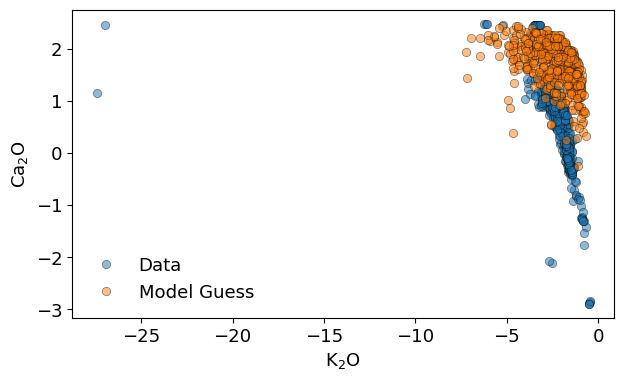

In [50]:
plt.figure(figsize = (7,4))
plt.plot(clr_data[:,0], clr_data[:,1], 'o', 
        markeredgewidth = 0.5, markeredgecolor = 'k', alpha = 0.5, 
        label = 'Data')

plt.plot(clr_model[:,0], clr_model[:,1], 'o',
        markeredgewidth = 0.5, markeredgecolor = 'k', alpha = 0.5,
         label = 'Model Guess')
plt.ylabel('Ca$_{2}$O')
plt.xlabel('K$_{2}$O')
#plt.xlim(-4.8, -1)
plt.legend(frameon = False)


# Priors
------------

In [51]:
def Grainitoid_Priors(comp_dict): 
    priors = {
        'K$_{2}$O': (4.3, 2.6),
        'CaO': (1.46, 2.52),
        'TiO$_{2}$': (0.29, 0.25),
        'SiO$_{2}$': (72.16, 8.05),
        'Al$_{2}$O$_{3}$': (13.9, 3),
        'Na$_{2}$O': (3.6, 2),
        'MgO': (0.63, 0.1),
        'FeO': (1.4, 2),
        'MnO': (0.05, 0.01),
        'Cl': (0.011, 0.03),
        'SO$_{3}$': (0.05, 0.42),
        'P$_{2}$O$_{5}$': (0.11, 0.33)
    }

    lp = 0
    for component, (mean_val, std_val) in priors.items():
        if component in comp_dict:
            lp += norm.logpdf(comp_dict[component], mean_val, std_val)
        else:
            raise ValueError(f"Component {component} not found in comp_dict")

    return lp

In [52]:
def Limestone_Prior(comp_dict):
    priors = {
        'K$_{2}$O': (1e-6, 1e-6),
        'CaO': (1, 0.03),
        'TiO$_{2}$': (1e-6, 1e-6),
        'SiO$_{2}$': (1e-6, 1e-6),
        'Al$_{2}$O$_{3}$': (1e-6, 1e-6),
        'Na$_{2}$O': (1e-6, 1e-6),
        'MgO': (1e-6, 1e-6),
        'FeO': (1e-6, 1e-6),
        'MnO': (1e-6, 1e-6),
        'Cl': (1e-6, 1e-6),
        'SO$_{3}$': (1e-6, 1e-6),
        'P$_{2}$O$_{5}$': (1e-6, 1e-6)
    }

    lp = 0
    for component, (mean_val, std_val) in priors.items():
        if component in comp_dict:
            lp += norm.logpdf(comp_dict[component], mean_val, std_val)
        else:
            raise ValueError(f"Component {component} not found in comp_dict")

    return lp

In [53]:
def Shale_Prior(comp_dict):
    priors = {
        'K$_{2}$O': (0.04, 0.06),
        'CaO': (0.024, 0.015),
        'TiO$_{2}$': (0.0009, 0.001),
        'SiO$_{2}$': (0.6, 0.05),
        'Al$_{2}$O$_{3}$': (0.185, 0.06),
        'Na$_{2}$O': (0.018, 0.02),
        'MgO':(0.029, 0.05),
        'FeO': (0.07,0.08),
        'MnO': (0.001, 0.001),
        'Cl': (0.00001, 0.00001),
        'SO$_{3}$': (0.000501, 0.00001),
        'P$_{2}$O$_{5}$': (0.002, 0.002)
    }

    lp = 0
    for component, (mean_val, std_val) in priors.items():
        if component in comp_dict:
            lp += norm.logpdf(comp_dict[component], mean_val, std_val)
        else:
            raise ValueError(f"Component {component} not found in comp_dict")

    return lp

In [54]:
def Mafic_Prior(comp_dict):
    priors = {
        'K$_{2}$O': (0.01, 0.015),
        'CaO': (0.023, 0.04),
        'TiO$_{2}$': (0.011, 0.03),
        'SiO$_{2}$': (0.435, 0.08),
        'Al$_{2}$O$_{3}$': (0.1, 0.03),
        'Na$_{2}$O': (0.006, 0.01),
        'MgO':(0.11, 0.08),
        'FeO': (0.13,0.09),
        'MnO': (0.0011, 0.002),
        'Cl': (0.00225, 0.00225),
        'SO$_{3}$': (0.0014, 0.002),
        'P$_{2}$O$_{5}$': (0.0011, 0.0015)
    }

    lp = 0
    for component, (mean_val, std_val) in priors.items():
        if component in comp_dict:
            lp += norm.logpdf(comp_dict[component], mean_val, std_val)
        else:
            raise ValueError(f"Component {component} not found in comp_dict")

    return lp 

In [55]:
def Dolomite_Prior(comp_dict):
    priors = {
        'K$_{2}$O': (1e-6,1e-6),
        'CaO': (0.51,0.1),
        'TiO$_{2}$': (1e-6, 1e-6),
        'SiO$_{2}$': (1e-6, 1e-6),
        'Al$_{2}$O$_{3}$': (1e-6, 1e-6),
        'Na$_{2}$O': (1e-6, 1e-6),
        'MgO':(0.4697,0.1),
        'FeO': (0.0112, 0.0212),
        'MnO': (1e-6, 1e-6),
        'Cl': (1e-6, 1e-6),
        'SO$_{3}$': (1e-6, 1e-6),
        'P$_{2}$O$_{5}$': (1e-6, 1e-6)
    }

    lp = 0
    for component, (mean_val, std_val) in priors.items():
        if component in comp_dict:
            lp += norm.logpdf(comp_dict[component], mean_val, std_val)
        else:
            raise ValueError(f"Component {component} not found in comp_dict")

    return lp

In [56]:
def Halite_Prior(comp_dict):
    priors = {
        'K$_{2}$O': (1e-6,1e-6),
        'CaO': (1e-6,1e-6),
        'TiO$_{2}$': (1e-6, 1e-6),
        'SiO$_{2}$': (1e-6, 1e-6),
        'Al$_{2}$O$_{3}$': (1e-6, 1e-6),
        'Na$_{2}$O': (0.5, 0.1),
        'MgO':(1e-6, 1e-6),
        'FeO': (1e-6, 1e-6),
        'MnO': (1e-6, 1e-6),
        'Cl': (0.5, 0.1),
        'SO$_{3}$': (1e-6, 1e-6),
        'P$_{2}$O$_{5}$': (1e-6, 1e-6)
    }

    lp = 0
    for component, (mean_val, std_val) in priors.items():
        if component in comp_dict:
            lp += norm.logpdf(comp_dict[component], mean_val, std_val)
        else:
            raise ValueError(f"Component {component} not found in comp_dict")

    return lp

In [57]:
def Anhydrite_Prior(comp_dict):
    priors = {
        'K$_{2}$O': (1e-6,1e-6),
        'CaO': (0.4,0.1),
        'TiO$_{2}$': (1e-6, 1e-6),
        'SiO$_{2}$': (1e-6, 1e-6),
        'Al$_{2}$O$_{3}$': (1e-6, 1e-6),
        'Na$_{2}$O':(1e-6, 1e-6),
        'MgO':(1e-6, 1e-6),
        'FeO': (1e-6, 1e-6),
        'MnO': (1e-6, 1e-6),
        'Cl': (1e-6, 1e-6),
        'SO$_{3}$': (0.6, 0.1),
        'P$_{2}$O$_{5}$': (1e-6, 1e-6)
    }

    lp = 0
    for component, (mean_val, std_val) in priors.items():
        if component in comp_dict:
            lp += norm.logpdf(comp_dict[component], mean_val, std_val)
        else:
            raise ValueError(f"Component {component} not found in comp_dict")

    return lp

In [58]:
def check_component_priors(component_type, comp_dict): 
    if component_type == "granitoid":
        return Granitoid_Prior(comp_dict)
    elif component_type == "shale":
        return Shale_Prior(comp_dict)
    elif component_type == "mafic":
        return Mafic_Prior(comp_dict)
    elif component_type == "halite":
        return Halite_Prior(comp_dict)
    elif component_type == "limestone":
        return Limestone_Prior(comp_dict)
    elif component_type == "anhydrite":
        return Anhydrite_Prior(comp_dict)
    elif component_type == "dolomite":
        return Dolomite_Prior(comp_dict)
    else: 
        return 0

def check_all_priors(components): 
    """
    Check if all component priors
    
    Parameters:
    components (list): A list of component dictionaries.
    
    Returns:
    bool: True if all components meet their constraints, False otherwise.
    """
    lp_values = []
    for component in components:
        component_type = list(component.keys())[0]
        feature_dict = component[component_type]
        
        lp = check_component_priors(component_type, feature_dict)
        lp_values.append(lp)
        
        if lp == -np.inf:
            return False, np.sum(lp_values)  # Return False if any component does not meet its constraints

        return True, np.sum(lp_values)  # Return True if all components meet their constraints

In [59]:
def logprior(components, mixture):
    """
    This function defines the prior 
    for the model parameters
    
    Returns
    -------
    
    LogPrior (float)
    """
    K = len(components)
    D, N = mixture.shape
    """
    Number of components prior
    """
    lp = log_Prior_K(K, 20) 

    
    """
    Non-negative and sum-to-one
    """
    components_val = Prepare_Components_for_Matrix(components)
    if np.any(components_val < 0) or np.any(mixture < 0):
        return -np.inf  # Violates non-negativity
    
    if not np.isclose(np.any(mixture.sum(axis = 1)), 1):
        return -np.inf  # Violates sum-to-one constraint
    
    """
    Prior to favour components 
    in the dictionary 
    """
    accept, comp_prior =  check_all_priors(components)
    if accept: 
        lp += comp_prior
    else: 
        return -np.inf
            
    return lp  

In [60]:
from scipy.stats import norm

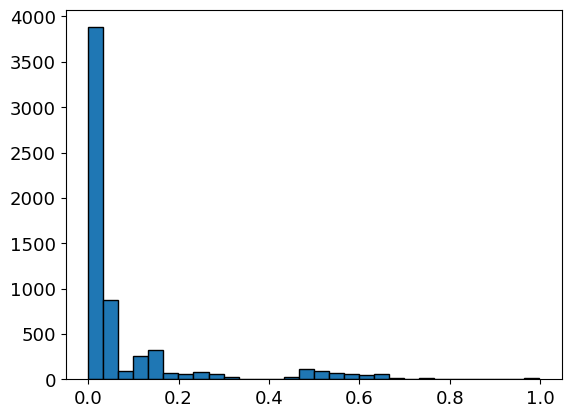

In [61]:
plt.hist(Clean_Data.flatten(), bins = 30, edgecolor = 'k'); 

In [62]:
np.median(Clean_Data.flatten())

0.013161132488736689

In [219]:
"""
Likelihood
"""
def loglikelihood(components, mixture):
    """
    This funciton takes the data and model 
    performs a centred-log transform and 
    then calculates the likelihood of the data 
    given the model for a given number of components and 
    mixture matrix
    
    Returns
    -------
    
    Log-likelihood (Float)
    """
    model = Geo_Model(mixture, components)
    
    Clean_Data[Clean_Data == 0] = 1e-11
    model[model == 0] = 1e-11
    
    clr_data = clr_transform(Clean_Data)
        
    clr_model = clr_transform(model)
    
    #sigma_data = 0.005 * Clean_Data

    #clr_err = sigma_data / Clean_Data

    clr_err = 0.005 * clr_data
    
    loglikelihood = - 0.5 * np.sum(((clr_model - clr_data) / clr_err)**2)
    
    return loglikelihood

In [220]:
"""
Posterior
"""
def logPosterior(components, mixture): 
    """
    This function calculates the posterior of 
    the model.
    
    log(likelihood) + log(Prior)
    
    Returns
    -------
    LogPosterior (Float)
    """
    
    LogLike = loglikelihood(components, mixture)
    LogPrior = logprior(components, mixture)
    
    return LogLike + LogPrior

In [221]:
select_comp = randomly_select_components(component_dict, num_samples=54)

In [222]:
select_comp = randomly_select_components(component_dict, num_samples=11)


# Moves
--------

In [223]:
def mixture_proposal(components, mixture, tuning_factors, index): 
    components_current = components
    mixture_current = mixture
    D, N = mixture.shape
    # Decide on the type of move
    move_type = np.random.choice(['adjust_component', 'some_components', 'whole_matrix_adjustment'])
    mixture_prime = np.copy(mixture_current)

    if move_type == 'adjust_component':
        if np.random.rand() < 0.5: 
            adjustment_scale = np.random.normal(0, 
                            0.05)
        else: 
            adjustment_scale = np.random.normal(0, 
                            0.1)
    
        mixture_prime[index] = np.abs(mixture_current[index] + adjustment_scale)
    
        # Normalize the mixture matrix
        mixture_prime /= mixture_prime.sum(axis=0, keepdims=True)

    elif move_type == 'some_components': 
        num_elements_to_adjust = np.random.randint(1, D*N)
        total_elements = D * N

        indices_to_adjust = np.random.choice(total_elements, num_elements_to_adjust, 
                                             replace = False)
        adjust_value = np.random.normal(0, 0.1, num_elements_to_adjust)

        flat_matrix = mixture_current.flatten()

        flat_matrix[indices_to_adjust] += adjust_value

        mixture_prime = abs(flat_matrix.reshape(D,N))
        

    elif move_type == 'whole_matrix_adjustment':
        # Adjust the whole mixture matrix slightly
        adjustment_matrix = np.random.normal(0, 0.1, (D,N))
        mixture_prime = np.abs(mixture_current + adjustment_matrix)
        mixture_prime /= mixture_prime.sum(axis=0, keepdims=True)

    # Evaluate models and posteriors
    model_prime = Geo_Model(mixture_prime, components_current)
    model_current = Geo_Model(mixture_current, components_current)

    current_posterior = logPosterior(components_current, mixture_current)
    proposed_posterior = logPosterior(components_current, mixture_prime)

    u = np.random.rand()
    if proposed_posterior > current_posterior or np.log(u) < (proposed_posterior - current_posterior):
        return mixture_prime, components_current, proposed_posterior, model_prime, True
    else:
        return mixture_current, components_current, current_posterior, model_current, False

In [821]:
def component_proposal(components, mixture):
    """
    This function changes the composition of an  
    end-member
    
    Returns
    -------
    Mixture, Components, Posterior, Model
    """
    components_current = components
    mixture_current = mixture
    current_posterior = logPosterior(components_current, 
                                     mixture_current)
    
    # Choose a random component to modify
    i = random.randint(0, len(components) - 1)
    selected_component = components[i]
    component_type = list(selected_component.keys())[0]
    feature_dict = selected_component[component_type]

    # Select a random feature to change
    feature_keys = list(feature_dict.keys())
    j = random.choice(feature_keys)

    # Make a copy of the components to propose changes
    components_prime = [dict(comp) for comp in components]  # Deep copy each component
    feature_prime = dict(feature_dict)  # Copy the selected component's features
    components_prime[i] = {component_type: feature_prime}


    # Modify the selected feature
    feature_prime[j] += np.random.normal(0, 0.01 * feature_prime[j])
    feature_prime[j] = abs(feature_prime[j])  # Ensure non-negativity

    # Normalize the modified component's features to sum to 1
    total = sum(feature_prime.values())
    for key in feature_keys:
        feature_prime[key] /= total


    if not check_all_constraints(components_prime):
        # If the constraints are not met, return the current state
        model_current = Geo_Model(mixture_current, components_current)
        return mixture_current, components_current, current_posterior, model_current, False

    
    proposed_posterior = logPosterior(components_prime, 
                                     mixture)

    model_prime = Geo_Model(mixture, 
                            components_prime)
    
    model_current = Geo_Model(mixture, 
                              components_current)
    
    u = np.random.rand()
    if proposed_posterior > current_posterior or np.log(u) < (proposed_posterior - current_posterior):
        mixture = mixture
        components = components_prime
        posterior = proposed_posterior
        model = model_prime
        return mixture, components, posterior, model, True

        
    else:
        mixture = mixture_current
        components = components_current
        posterior = current_posterior
        model = model_current
        
        return mixture, components, posterior, model, False

In [822]:
def component_swap(components, mixture):
    """
    This function suggests swapping the composition of one or more 
    end-members with no change in dimensionality.
    Returns
    -------
    Mixture, Components, Posterior, Model
    """
    
    components_current = components
    mixture_current = mixture
    K = len(components)
    current_posterior = logPosterior(components_current, mixture_current)
    
    # Determine the number of components to modify (1 to max_k)
    num_swaps = random.randint(1, min(K, K))
    
    # Select random components to modify
    indices_to_modify = random.sample(range(K), num_swaps)
    
    components_prime = [dict(comp) for comp in components]  # Deep copy each component
    
    for i in indices_to_modify:
        # Choose a component from the component dictionary
        random_component_key = random.choice(list(component_dict.keys()))
        components_prime[i] = {random_component_key: component_dict[random_component_key]}  # Swap with a component from the dictionary
    
    model_prime = Geo_Model(mixture, components_prime)
    model_current = Geo_Model(mixture, components_current)

    if not check_all_constraints(components_prime):
        # If the constraints are not met, return the current state
        return mixture_current, components_current, current_posterior, model_current, False
    
    """
    Acceptance
    """
    
    proposed_posterior = logPosterior(components_prime, mixture)
    
    u = np.random.rand()
    if proposed_posterior > current_posterior or np.log(u) < (proposed_posterior - current_posterior):
        return mixture, components_prime, proposed_posterior, model_prime, True
    else:
        return mixture_current, components_current, current_posterior, model_current, False 
    

In [226]:
def mixture_swap(components, mixture):
    """
    This function suggest swapping a component 
    with another, keeping all other variables the same
    
    Returns
    -------
    Mixture, Components, Posterior, Model
    """
    components_current = components
    mixture_current = mixture
    
    mixture_prime = np.copy(mixture)
    

    i, j = np.random.choice(len(mixture_prime), 
                            size=2, 
                            replace=False)
    
    selection = np.random.uniform()
    
    if selection < 0.5: 
        mixture_prime[i], mixture_prime[j] = mixture_prime[j], mixture_prime[i]
    else: 
        mixture_prime[i, :], mixture_prime[j, :] = mixture_prime[j, :], mixture_prime[i, :]
    
    
    model_prime = Geo_Model(mixture_prime, components_current)
    
    model_current = Geo_Model(mixture, components_current)
    
    """
    Acceptance
    """
    current_posterior = logPosterior(components_current, 
                                     mixture_current)
    
    proposed_posterior = logPosterior(components_current, 
                                     mixture_prime)
 
    u = np.random.rand()
    if proposed_posterior > current_posterior or np.log(u) < (proposed_posterior - current_posterior):    
        mixture = mixture_prime
        components = components_current
        posterior = proposed_posterior
        model = model_prime
        return mixture, components, posterior, model, True
    else:
        mixture = mixture_current
        components = components_current
        posterior = current_posterior
        model = model_current
        
    return mixture, components, posterior, model, False


In [227]:
def select_random_component():
    """
    Randomly selects one component from the component dictionary
    """
    key = random.choice(list(component_dict.keys()))
    return key, component_dict[key]

In [228]:
def component_birth(components, mixture): 
    """
    This function defines the birth proposal function
    
    Returns
    -------
    Mixture
    Components
    Posterior
    Model
    """
    components_current = components
    mixture_current = mixture

    current_posterior = logPosterior(components_current, 
                                     mixture_current)

    N = mixture.shape[1]
    
    """
    New component 
     - Select from dictionary 
    """
    j = np.random.choice(select_random_component())
    selected_component_key = random.choice(list(component_dict.keys()))
    component_new = {selected_component_key: component_dict[selected_component_key]}

    """
    New Mixing vector
    """
    alpha2 = np.ones(N)
    mixing_new = np.random.dirichlet(alpha2, 1).reshape(1, N)
    
    """
    Add this into the component matrix
    and mixing matrix
    """
    
    components_prime = components_current + [component_new]   

    
    mixture_prime = np.concatenate([mixture,
                                    mixing_new],
                                     axis = 0)    

    if not check_all_constraints(components_prime):
        # If the constraints are not met, return the current state
        model_current = Geo_Model(mixture_current, components_current)
        return mixture_current, components_current, current_posterior, model_current, False
    
    model_prime = Geo_Model(mixture_prime, components_prime)
    
    model_current = Geo_Model(mixture, components_current)
    
    """
    Acceptance
    """
    current_posterior = logPosterior(components_current, 
                                     mixture_current)
    
    proposed_posterior = logPosterior(components_prime, 
                                     mixture_prime)
    
    u = np.random.rand()
    if proposed_posterior > current_posterior or np.log(u) < (proposed_posterior - current_posterior):
        mixture = mixture_prime
        components = components_prime
        posterior = proposed_posterior
        model = model_prime
        return mixture, components, posterior, model, True
        
    else:
        mixture = mixture_current
        components = components_current
        posterior = current_posterior
        model = model_current
        
        return mixture, components, posterior, model, False


In [229]:
def component_death(components, mixture): 
    """
    This function defines the death proposal function
    
    Returns
    -------
    Mixture, Components, Posterior, Model
    """
    components_current = components
    mixture_current = mixture
    K = len(components)
    
    # Select a component to delete
    j = random.randint(0, K - 1)
    
    # Add this into the component matrix and mixing matrix
    components_prime = [comp for idx, comp in enumerate(components) if idx != j]
    mixture_prime = np.delete(mixture, j, axis=0)
    mixture_prime /= mixture_prime.sum(axis=0)


    model_prime = Geo_Model(mixture_prime, components_prime)
    model_current = Geo_Model(mixture, components_current)
    
    
    """
    Acceptance
    """
    current_posterior = logPosterior(components_current, 
                                     mixture_current)
    
    proposed_posterior = logPosterior(components_prime,
                                     mixture_prime)


    if not check_all_constraints(components_prime):
        # If the constraints are not met, return the current state
        model_current = Geo_Model(mixture_current, components_current)
        return mixture_current, components_current, current_posterior, model_current, j, False
    
    
    u = np.random.rand()
    if proposed_posterior > current_posterior or np.log(u) < (proposed_posterior - current_posterior):
        mixture = mixture_prime
        components = components_prime
        posterior = proposed_posterior
        model = model_prime
        return mixture, components, posterior, model, j, True
        
    else:
        mixture = mixture_current
        components = components_current
        posterior = current_posterior
        model = model_current
        
        return mixture, components, posterior, model, j, False


In [230]:
def component_merge(components, mixture): 
    """
    This function defines a merge proposal where the model selects
    two similar components and merges their compositions and mixture 
    weights. Dimensionality reduces by 1. 
    
    Returns
    -------
    Mixture, Components, Posterior, Model
    """
    components_current = components
    mixture_current = mixture
    current_posterior = logPosterior(components_current, 
                                     mixture_current)

    K = len(components)
    
    # Find components of the same type
    component_types = [list(comp.keys())[0] for comp in components]
    unique_types = list(set(component_types))
    
    # Identify pairs of components of the same type
    pairs = [(i, j) for i in range(K) for j in range(i + 1, K) if component_types[i] == component_types[j]]

    if not pairs:
        return mixture, components, logPosterior(components, mixture), Geo_Model(mixture, components), None, False
    # Randomly select a pair to merge
    i, j = random.choice(pairs)
    
    # Merge Components
    component_type = component_types[i]
    component_i = components[i][component_type]
    component_j = components[j][component_type]
    
    merged_component = {k: (component_i[k] + component_j[k]) / 2 for k in component_i.keys()}
    component_merge = {component_type: merged_component}
    
    # Merge Mixture
    mixture_merge = (mixture[i] + mixture[j]) / 2
    mixture_merge = mixture_merge.reshape(1, -1)

    # Delete the components
    mixture_delete = np.delete(mixture_current, [i, j], axis=0)
    components_delete = [comp for idx, comp in enumerate(components_current) if idx not in [i, j]]
    
    # New Components and Mixture
    components_prime = components_delete + [component_merge]
    mixture_prime = np.concatenate([mixture_delete, mixture_merge], axis=0)

    # Normalize the mixture_prime
    mixture_prime /= mixture_prime.sum(axis=0)

    if not check_all_constraints(components_prime):
        # If the constraints are not met, return the current state
        model_current = Geo_Model(mixture_current, components_current)
        return mixture_current, components_current, current_posterior, model_current, None, False

    
    
    model_prime = Geo_Model(mixture_prime, components_prime)
    model_current = Geo_Model(mixture, components_current)
    
    # Acceptance
    proposed_posterior = logPosterior(components_prime, mixture_prime)
    
    u = np.random.rand()
    if proposed_posterior > current_posterior or np.log(u) < (proposed_posterior - current_posterior):
        mixture = mixture_prime
        components = components_prime
        posterior = proposed_posterior
        model = model_prime
        return mixture, components, posterior, model, (i, j), True
    else:
        mixture = mixture_current
        components = components_current
        posterior = current_posterior
        model = model_current
        return mixture, components, posterior, model, (i, j), False

In [231]:
def randomly_select_components(component_dict, num_samples=20):
    # Extract keys from the dictionary
    keys = list(component_dict.keys())
    # Randomly select keys, allowing for the same key to be selected multiple times
    selected_keys = random.choices(keys, k=num_samples)

    # Create a list to hold dictionaries for each selected component
    component_list = []
    for key in selected_keys:
        # Create a new dictionary for each selected component
        component_list.append({key: component_dict[key]})

    return component_list

In [232]:
def initialize_Mixture_Model(component_dict, min_comp, max_comp):
    N = np.random.randint(min_comp, max_comp)
    # Randomly select components from the component dictionary
    selected_components = randomly_select_components(component_dict, N)
    
    Mixture_Matrix_guess = np.random.dirichlet(np.ones(Clean_Data.shape[0]), N)
    
    return selected_components, Mixture_Matrix_guess

In [233]:
def Initial_Guesses_for_Model(n_chains):
    In_models = []
    minimum_components = 3
    maximum_components = 30
    for i in range(n_chains): 
        log_post = -np.inf
        Checking = False
        while True: 
            Initial_comp, Initial_mix = initialize_Mixture_Model(component_dict,
                                                                      minimum_components, 
                                                                      maximum_components)
            Checking = check_all_constraints(Initial_comp)
            log_post = logPosterior(Initial_comp, Initial_mix)
    
            if log_post != -np.inf and Checking == True:
                In_models.append((Initial_comp, Initial_mix))
                break  # Exit the loop since both conditions are satisfied
                
    return In_models

In [234]:
Initialize_Models = Initial_Guesses_for_Model(10)

# Tuning Factor Functions 
---------

In [235]:
def adjust_tuning_factors(tuning_factors, current_acceptance_rate,
                          target=0.234, increase_factor=1.1, 
                          decrease_factor=0.9):
    
    adjustment_factor = np.where(current_acceptance_rate > target, increase_factor, decrease_factor)
    new_tuning_factors = tuning_factors * adjustment_factor
    # Ensure tuning factors remain within sensible bounds
    new_tuning_factors = np.clip(new_tuning_factors, a_min=0.0000001, a_max=1000000.0)
    return new_tuning_factors


In [236]:
def expand_tuning_factors(tuning_factors, initial_tuning_value=0.1):
    # Assuming tuning_factors is a 2D array with shape (K, N)
    K, N = tuning_factors.shape
    new_row = np.full((1, N), initial_tuning_value)  # Create a row for the new component
    tuning_factors = np.vstack((tuning_factors, new_row))  # Add the new row
    return tuning_factors

In [237]:
def contract_tuning_factors(tuning_factors, i):
    # Remove the i-th row corresponding to the removed component
    tuning_factors = np.delete(tuning_factors, i, axis=0)
    return tuning_factors

In [238]:
def adjust_tuning_factors_for_merge(tuning_factors, indices, initial_tuning_value=0.1):
    """
    Adjust the tuning factors array after merging two components.

    Parameters:
    - tuning_factors: The current array of tuning factors.
    - indices: A tuple (i, j) of indices for the components being merged.
    - initial_tuning_value: The initial tuning value for the new merged component.

    Returns:
    - Updated tuning factors array.
    """
    i, j = indices

    # Remove the tuning parameters for the merged components
    tuning_factors = np.delete(tuning_factors, [i, j], axis=0)

    # Add a new tuning parameter for the merged component
    new_row = np.full((1, tuning_factors.shape[1]), initial_tuning_value)
    tuning_factors = np.vstack([tuning_factors, new_row])

    return tuning_factors

# Markov Chain Monte Carlo 
--------

In [674]:
"""
Full Model
"""
def MicroTektite_MCMC(data, components, mixture, niters, chain_id): 
    """
    Shapes
    """
    D = data.shape[1]
    N = data.shape[0]
    K = len(components)
    
    max_components = 50
    initial_tuning_value = 0.1

    num_components_storage = np.zeros(niters)
    posterior_storage = np.zeros(niters)
    components_storage = []
    mixture_storage = []
    model_storage = []

    tuning_factors_file = f'tuning_factors_Tektite_4092024_{chain_id}.pkl'

    if os.path.exists(tuning_factors_file):
        with open(tuning_factors_file, 'rb') as f:
            tuning_factors = pickle.load(f)
    else:
        tuning_factors = np.full((K, N), initial_tuning_value)
    
    accept_count = 0
    total_proposals = 0
    posterior_storage[0] = logPosterior(components,
                                        mixture)
    
    components_storage.append(components)
    mixture_storage.append(mixture)
    
    model = Geo_Model(mixture, components)
    model_storage.append(model)
    
    for i in range(1, niters):
        move_choice = np.random.uniform()
            
        if move_choice < 0.15: 
            new_mixture, new_components, new_posterior, new_model, accepted = component_proposal(components, mixture)
            if accepted:
                components = new_components
                mixture = new_mixture
                model = new_model
                new_theta = (new_components, new_mixture)
                theta = new_theta
        
        elif 0.15 < move_choice < 0.3: 
            index = (np.random.choice(K), np.random.choice(N))
            new_mixture, new_components, new_posterior, new_model, accepted = mixture_proposal(components, mixture, tuning_factors, index)
            if accepted:
                components = new_components
                mixture = new_mixture
                model = new_model
                new_theta = (new_components, new_mixture)
                theta = new_theta
                accept_count += 1
            total_proposals += 1
            
        elif 0.3 < move_choice < 0.45: 
            new_mixture, new_components, new_posterior, new_model, accepted = mixture_swap(components, mixture)
            if accepted:
                components = new_components
                mixture = new_mixture
                model = new_model
                new_theta = (new_components, new_mixture)
                theta = new_theta
            
        elif  0.45 < move_choice < 0.6:    
            new_mixture, new_components, new_posterior, new_model, accepted = component_swap(components, mixture)
            if accepted:
                components = new_components
                mixture = new_mixture
                model = new_model
                new_theta = (new_components, new_mixture)
                theta = new_theta
                
        elif 0.6 < move_choice < 0.85 and K < max_components:
            new_mixture, new_components, new_posterior, new_model, accepted = component_birth(components, mixture)
            if accepted:
                components = new_components
                mixture = new_mixture
                model = new_model
                new_theta = (new_components, new_mixture)
                theta = new_theta
                tuning_factors = expand_tuning_factors(tuning_factors)
                
        elif move_choice > 0.85 and K > 2:
            selection = np.random.rand()
            
            if selection < 0.5: 
                new_mixture, new_components, new_posterior, new_model, index, accepted = component_death(components, mixture)
                if accepted:
                    components = new_components
                    mixture = new_mixture
                    model = new_model
                    new_theta = (new_components, new_mixture)
                    theta = new_theta
                    tuning_factors = contract_tuning_factors(tuning_factors, index)
            else:
                new_mixture, new_components, new_posterior, new_model, indices, accepted = component_merge(components, mixture)
                if accepted:
                    components = new_components
                    mixture = new_mixture
                    model = new_model
                    new_theta = (new_components, new_mixture)
                    theta = new_theta
                    tuning_factors = adjust_tuning_factors_for_merge(tuning_factors, indices, initial_tuning_value=0.1)


        
        K = len(components)
        num_components_storage[i] = K
        posterior_storage[i] = logPosterior(components,
                                       mixture)
        components_storage.append(components)
        mixture_storage.append(mixture)
        model_storage.append(model)

        if (i + 1) % 777 == 0:
            current_acceptance_rate = accept_count / (i / len(tuning_factors))
            tuning_factors = adjust_tuning_factors(tuning_factors, current_acceptance_rate)
            
        if (i + 1) % 1000 == 0:
            mixture_filename = f'mixture_partZ_{chain_id}.pkl'
            components_filename = f'component_partZ_{chain_id}.pkl'
            with open(mixture_filename, 'wb') as f: 
                pickle.dump(mixture_storage[-1], f)
            with open(components_filename, 'wb') as f: 
                pickle.dump(components_storage[-1], f)
            with open(f'tuning_factors_Tektite_4092024_{chain_id}.pkl', 'wb') as f: 
                pickle.dump(tuning_factors, f)
    
    
    return num_components_storage, posterior_storage, components_storage, model_storage, mixture_storage, theta


In [675]:
def initialize_Mixture_Model(component_dict, min_comp, max_comp):
    N = np.random.randint(min_comp, max_comp)
    """
    Generate random models for initialization
    """
    # Randomly select components from the component dictionary
    selected_components = randomly_select_components(component_dict, num_samples=N)
    
    Mixture_Matrix_guess = np.random.dirichlet(np.ones(Clean_Data.shape[0]), N)
    
    return selected_components, Mixture_Matrix_guess
    

In [676]:
n_chains = 10
In_models = []

for i in range(n_chains):
    log_post = -np.inf
    Checking = False
    while True:  # This ensures the loop continues until you manually break out of it
        Initial_comp, Initial_mix = initialize_Mixture_Model(component_dict, 3, 40)
        Checking = check_all_constraints(Initial_comp)
        log_post = logPosterior(Initial_comp, Initial_mix)

        if log_post != -np.inf and Checking == True:
            In_models.append((Initial_comp, Initial_mix))
            break  # Exit the loop since both conditions are satisfied


In [677]:
for i in range(n_chains): 
    print(f'Initial_{i}', logPosterior(In_models[i][0],
                                             In_models[i][1]), check_all_constraints(In_models[i][0]))

Initial_0 -100515786962.8947 True
Initial_1 -79249947733.60042 True
Initial_2 -2023018727052.168 True
Initial_3 -33366071699.125412 True
Initial_4 -99375947345.9456 True
Initial_5 -260523591702.0309 True
Initial_6 -334678095746.51514 True
Initial_7 -37776287003.74502 True
Initial_8 -206994283451.65924 True
Initial_9 -205774620202.61096 True


In [678]:
#from joblib import Parallel, delayed
##
#iters = 1001  # Number of iterations per chain
#chain_id = np.arange(n_chains)
##
#def run_chain(initial_components, 
#              initial_mixture, 
#              chain_id, 
#              data, iters):
##    """
##    Returns:
##    - Result of the MCMC simulation.
##    """
##    
##    # Set a different seed for each chain 
#    np.random.seed()
##    
##    # Run the MCMC simulation
#    return  MicroTektite_MCMC(data, initial_components, 
#                          initial_mixture, iters, chain_id)
##
### Assuming In_models contains tuples of (initial_components, initial_mixture) 
#results = Parallel(n_jobs=-1)(
#    delayed(run_chain)(In_models[chain_id][0],
#                       In_models[chain_id][1], 
#                       chain_id, 
#                       Clean_Data, 
#                       iters) 
#    for chain_id in range(n_chains))

In [833]:
all_model_pickles = []
cwd = os.chdir('/Users/johncarter/Tektite Analysis')
for chain_id in range(n_chains):
    with open(f'mixture_partZ_{chain_id}.pkl', 'rb') as f: 
        mixture_p = pickle.load(f)
    with open(f'component_partZ_{chain_id}.pkl', 'rb') as f: 
        component_p = pickle.load(f)

    model_pickles = (component_p, mixture_p)
    all_model_pickles.append(model_pickles)

In [834]:
for i in range(n_chains): 
    print(f'Pickles_{i}', logPosterior(all_model_pickles[i][0],
                                    all_model_pickles[i][1]), 
         check_all_constraints(all_model_pickles[i][0]));

Pickles_0 -7972817.934850025 True
Pickles_1 -7994940.939196121 True
Pickles_2 -7863780.520480784 True
Pickles_3 -8061811.021438726 True
Pickles_4 -7929387.121376316 True
Pickles_5 -8399246.371868817 True
Pickles_6 -8156079.332279884 True
Pickles_7 -7882660.1768435845 True
Pickles_8 -8190148.61832429 True
Pickles_9 -9513115.173219552 True


In [835]:

# Load the posteriors dictionary from a file if it exists
if os.path.exists('tektite_posterior_testing_priors_tr5.pkl'):
    with open('tektite_posterior_testing_priors_tr5.pkl', 'rb') as f:
        posterior_dict = pickle.load(f)
        print('File exists and is loaded')
else:
    posterior_dict = {f'chain_{i}': [] for i in range(n_chains)}
    print('Posterior dictionary does not already exist but is now an empty tuple')

File exists and is loaded


In [836]:
from joblib import Parallel, delayed

for _ in range(4000):
    iters = 5001  # Number of iterations per chain
    chain_id = np.arange(n_chains)
    
    all_model_pickles = []

    
    
    for chain_id in range(n_chains):
        with open(f'mixture_partZ_{chain_id}.pkl', 'rb') as f: 
            mixture_p = pickle.load(f)
        with open(f'component_partZ_{chain_id}.pkl', 'rb') as f: 
            component_p = pickle.load(f)
    
        model_pickles = (component_p, mixture_p)
        all_model_pickles.append(model_pickles)
        
        chain_posteriors = logPosterior(all_model_pickles[chain_id][0],
                                    all_model_pickles[chain_id][1])
        
        posterior_dict[f'chain_{chain_id}'].append(chain_posteriors)

    if (_ + 1) % 5 == 1:

        print(f'Pickles_{i}', logPosterior(all_model_pickles[i][0],
                                    all_model_pickles[i][1]), 'iteration', _)
    
    def run_chain(initial_components, initial_mixture, chain_id, data, iters):
        """
        Returns:
        - Result of the MCMC simulation.
        """
        
        # Set a different seed for each chain 
        np.random.seed()
        
        # Run the MCMC simulation
        return MicroTektite_MCMC(data, initial_components, 
                              initial_mixture, iters, chain_id)
    
    results = Parallel(n_jobs=-1)(
        delayed(run_chain)(all_model_pickles[chain_id][0],
                           all_model_pickles[chain_id][1], 
                           chain_id, 
                           Clean_Data, 
                           iters) 
        for chain_id in range(n_chains))

    with open('tektite_posterior_testing_priors_tr5.pkl', 'wb') as f: 
                pickle.dump(posterior_dict, f)

Pickles_9 -9513115.173219552 iteration 0
Pickles_9 -9512919.323649062 iteration 5
Pickles_9 -9512615.365212299 iteration 10
Pickles_9 -9512193.715977488 iteration 15
Pickles_9 -9511751.484754946 iteration 20
Pickles_9 -9511289.151821876 iteration 25
Pickles_9 -9510447.37684969 iteration 30
Pickles_9 -9509891.267704116 iteration 35
Pickles_9 -9509322.464317596 iteration 40
Pickles_9 -9509133.62495281 iteration 45
Pickles_9 -9508702.624912294 iteration 50
Pickles_9 -9508136.30598964 iteration 55
Pickles_9 -9507619.017629413 iteration 60
Pickles_9 -9507420.942159913 iteration 65
Pickles_9 -9507010.599787844 iteration 70
Pickles_9 -9506388.67131679 iteration 75
Pickles_9 -9505874.817296216 iteration 80
Pickles_9 -9505511.05015574 iteration 85
Pickles_9 -9503765.26024845 iteration 90
Pickles_9 -9503442.025863811 iteration 95
Pickles_9 -9502946.777453529 iteration 100
Pickles_9 -9502492.965301087 iteration 105
Pickles_9 -9502031.214359326 iteration 110
Pickles_9 -9500229.991379397 iteration 

In [839]:
len(posterior_dict['chain_0'])

71859

In [840]:
burn = int(iters);

In [841]:
"""
Unpack Chain Variables
----------------------
"""
z_vars = [f"z{i+1}" for i in range(6)]
for chain_id in range(1, n_chains + 1):
    for z_var in z_vars:
        vars()[f"{z_var}_{chain_id}"] = results[chain_id - 1][z_vars.index(z_var)]

In [842]:
"""
Make a Results Dictionary for plotting
"""
result_dicts = []

for chain_id, result in enumerate(results, start=1):
    result_dict = {}
    for var_name, value in zip(z_vars, result):
        result_dict[f"{var_name}_{chain_id}"] = value
    result_dicts.append(result_dict)

In [843]:
"""
Plot Global Posterior
"""
x = np.arange(0, len(posterior_dict['chain_0']) * 1000,1 +  len(posterior_dict['chain_0']))

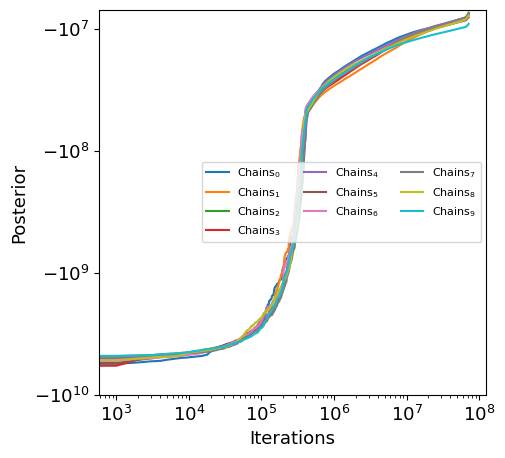

In [844]:
plt.figure(figsize = (5,5))
for i in range(10): 
    plt.plot(np.arange(len(posterior_dict[f'chain_{i}']))*1000, posterior_dict[f'chain_{i}'], 
            label = f'Chains$_{i}$')
plt.xlabel(r'Iterations')
plt.ylabel('Posterior')
plt.xscale('log')
plt.yscale('symlog')
plt.legend(ncol = 3, 
           fontsize =8)

plt.ylim(-1e10, -0.7e7)
plt.savefig('Log_p_tektites.png', 
            bbox_inches = 'tight', dpi = 300)

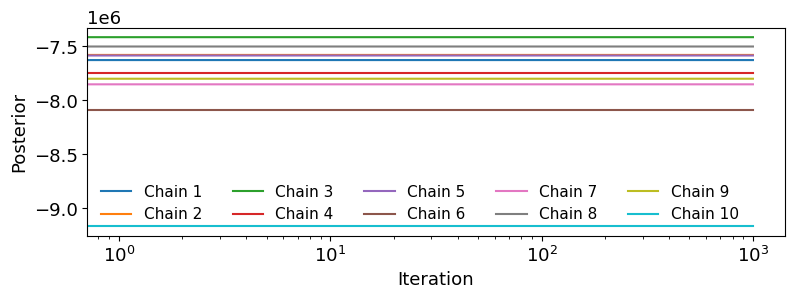

In [845]:
"""
List of
chains
"""
log_p = []
burn = 1000
for i in range(1, n_chains + 1):
    chain_dict = result_dicts[i-1]  # get the dictionary for chain i
    log_p.append(chain_dict[f"z2_{i}"][-burn:]) 

fig, ax = plt.subplots(1,1, figsize = (9,
                                       2.7))

for i in range(n_chains):
    ax.plot(log_p[i], 
           label = f'Chain {i + 1}')
    
ax.set_xlabel('Iteration')
ax.set_ylabel('Posterior')
ax.legend(frameon = False, 
         loc = 3, fontsize = 11, ncol = 5)
ax.set_xscale('log'); 

In [846]:
"""
Components
"""
Components = []
for i in range(1, n_chains + 1):
    chain_dict = result_dicts[i-1]  # get the dictionary for chain i
    Components.append(chain_dict[f"z1_{i}"]) 

In [847]:
"""
Composition
"""
Compositions = []
for i in range(1, n_chains + 1):
    chain_dict = result_dicts[i-1]  # get the dictionary for chain i
    Compositions.append(chain_dict[f"z3_{i}"]) 

In [848]:
"""
Assumptions
- The between component variances is going to dominate 
- Will only consider uncertainties from the combined like components
"""
from collections import defaultdict

# Prepare a dictionary to hold the values for each component type
component_values = defaultdict(lambda: defaultdict(list))

# Iterate through each entry in the data list
for entry in Compositions[0][-1]:
    for key, values in entry.items():
        for compound, amount in values.items():
            component_values[key][compound].append(amount)

# Calculate mean and standard deviation for each component under each key
stats = {}
for key, compounds in component_values.items():
    stats[key] = {}
    for compound, values in compounds.items():
        mean = np.mean(values)
        std = np.std(values)
        stats[key][compound] = {'mean': mean, 'std': std}

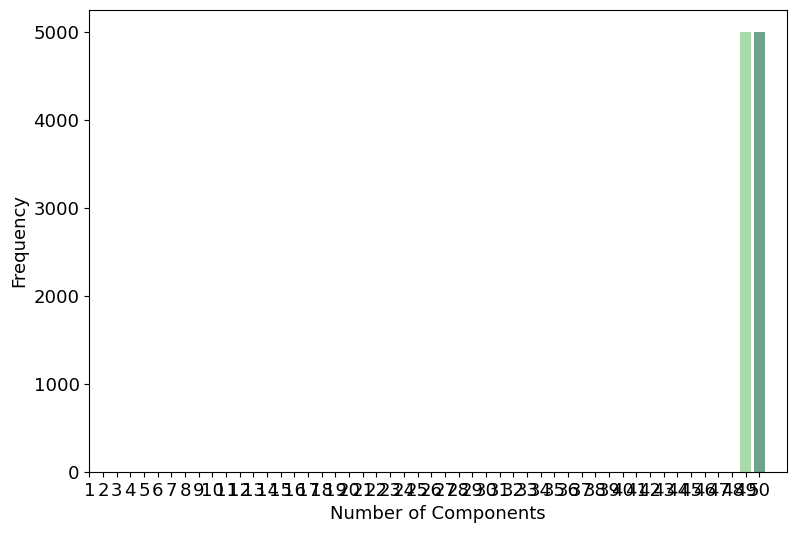

In [849]:
fig, ax = plt.subplots(1,1, figsize = (9,6))

for i in range(n_chains): 
    
    unique_components, counts = np.unique(Components[i], 
                    return_counts=True)
    plt.xlim(Components[i].min() - 1, 
         Components[i].max() + 1)

    plt.bar(unique_components, counts, 
       alpha = 0.4, lw = 1.3)
plt.xlabel('Number of Components')
plt.ylabel('Frequency')
plt.xticks(np.linspace(0, 50, 51))
plt.xlim(1,52)
plt.show()

In [850]:
"""
Need to 
select the 
number of 
components
"""

'\nNeed to \nselect the \nnumber of \ncomponents\n'

In [851]:
selected_components = np.zeros(n_chains)
for i in range(n_chains):
    unique_components, counts = np.unique(Components[i], return_counts=True)
    # Identify the most frequent component in this chain
    max_count_index = np.argmax(counts)
    selected_components[i] = unique_components[max_count_index]
    # Get the indices of the selected component in the original Components array
    selected_indices = np.where(Components[i][-1] == selected_components)[0]
    
    # Plotting the compositions for the selected component
    
    

In [852]:
selected_components

array([50., 50., 49., 50., 50., 50., 50., 50., 50., 50.])

In [853]:
"""
Model
"""
Models = []
for i in range(1, n_chains + 1):
    chain_dict = result_dicts[i-1]  # get the dictionary for chain i
    Models.append(chain_dict[f"z4_{i}"][-burn:]) 

In [854]:

n_chains = len(result_dicts)  
all_means = []
all_stds = []

for i in range(n_chains):
    chain_dict = result_dicts[i]
    Model_ = chain_dict[f"z4_{i+1}"][-burn:]  # Get the last n models for chain i
    
    # Calculate mean and std for the current chain
    Model_mean = np.mean(Model_, axis=0)
    Model_std = np.std(Model_, axis=0)
    
    # Append results to lists
    all_means.append(Model_mean)
    all_stds.append(Model_std)
    

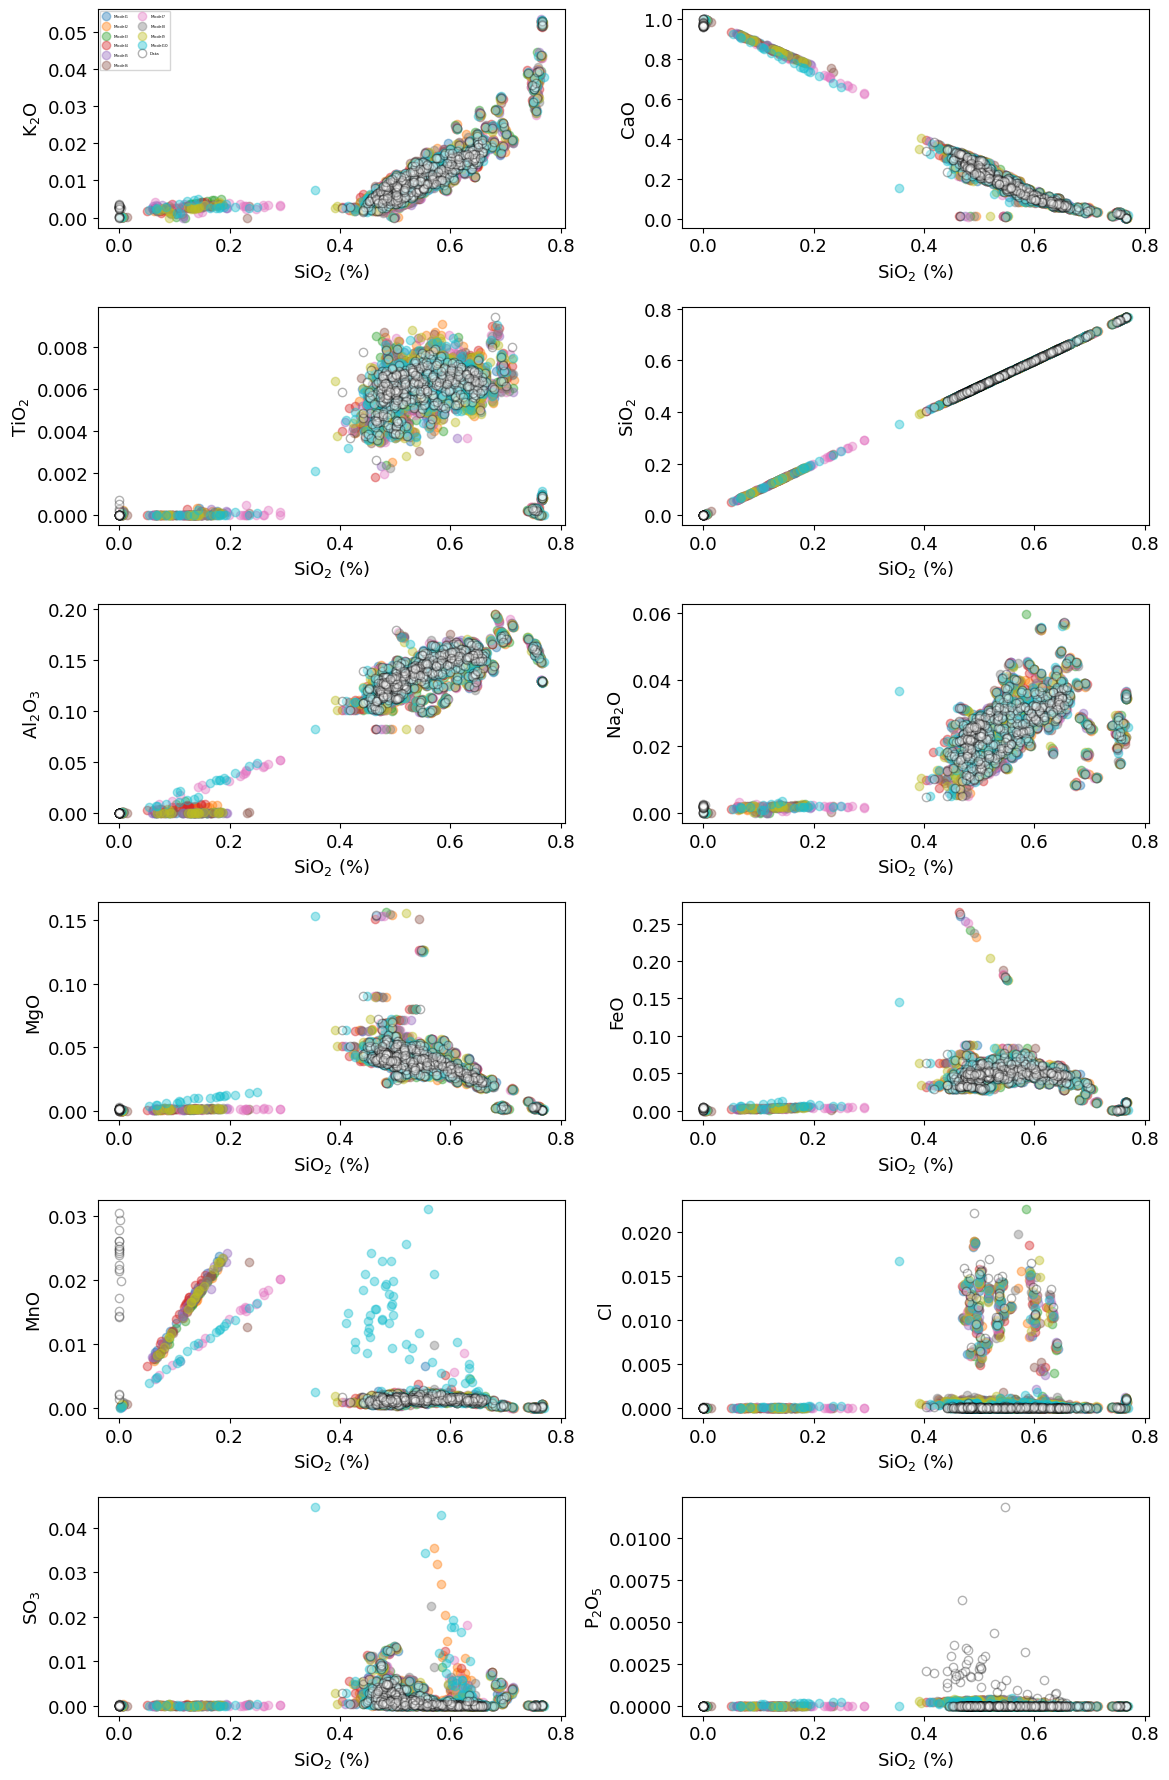

In [855]:
# Define feature labels for the y-axis
feature_labels_y = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
                    'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO',
                    'FeO', 'MnO', 'Cl', 'SO$_{3}$', 'P$_{2}$O$_{5}$']
si02_index = 3  # Index for SiO2 in your data arrays, used as the x-axis

fig, axs = plt.subplots(6, 2, figsize=(12, 18))
axs = axs.ravel()

for i, label in enumerate(feature_labels_y):
    ax = axs[i]
    
    for j in range(n_chains):
        ax.plot(all_means[j][:, si02_index], 
                all_means[j][:, i],
                'o', alpha=0.4, 
                zorder=0, 
                label=f'Model$_{j + 1}$' if i == 0 else "")

    # Plotting the data points
    ax.plot(Clean_Data[:, si02_index],
            Clean_Data[:, i], 'o',
            alpha=0.3, 
            markerfacecolor='w', 
            markeredgewidth=1, 
            markeredgecolor='k',
            label='Data' if i == 0 else "")
    
    ax.set_xlabel('SiO$_{2}$ (%)')
    ax.set_ylabel(label)
    
    if i == 0:
        ax.legend(fontsize=3,
                  loc='best', 
                  ncol = 2)

# If the number of plots does not fill the last row, turn off the remaining axes
for ax in axs[len(feature_labels_y):]:
    ax.axis('off')

plt.tight_layout()



In [856]:
"""
Mixture weights
"""
Mixtures = []

for i in range(1, n_chains + 1): 
    chain_dict = result_dicts[i-1]  # get the dictionary for chain i
    Mixtures.append(chain_dict[f"z5_{i}"]) 

In [857]:
"""
Get Mean and stdev component vectors
"""
component_mean_weights = []
component_mean_uncertainties =[]
burn = 5
for i in range(n_chains):
    component_mixtures = np.array(Mixtures[i][-burn:])
    
    comp_mean_sum = np.sum(component_mixtures, axis=2)
    comp_mean_norm = comp_mean_sum/(comp_mean_sum.sum(axis = 1, keepdims = True))
    component_mean_weights.append(comp_mean_norm.mean(axis = 0))
    component_mean_uncertainties.append(comp_mean_norm.std(axis = 0))
                                                                  
    

In [858]:
weights = component_mean_weights[0]
uncertainties = component_mean_uncertainties[0]

In [859]:
# To store aggregated compositions
aggregate_data = defaultdict(lambda: {
    'composition': defaultdict(list),
    'weight': 0,
    'weight_uncertainty_squared': 0
})

# Process data
for index, comp_dict in enumerate(Compositions[0][-1]):
    for key, comp in comp_dict.items():
        if 'random' in key:
            # Treat random entries uniquely
            suffix = key.split('_')[1] if '_' in key else index
            random_key = f"random_{suffix}"
            aggregate_data[random_key] = {
                'composition': comp,
                'weight': weights[index],
                'weight_uncertainty': uncertainties[index]
            }
        else:
            # Aggregate like entries
            aggregate_data[key]['weight'] += weights[index]
            aggregate_data[key]['weight_uncertainty_squared'] += uncertainties[index]**2
            for compound, value in comp.items():
                aggregate_data[key]['composition'][compound].append(value)

# Calculate means, std deviations, and total uncertainties
final_results = {}
for key, data in aggregate_data.items():
    if 'random' in key:
        final_results[key] = data
    else:
        final_results[key] = {
            'composition': {},
            'weight': data['weight'],
            'weight_uncertainty': np.sqrt(data['weight_uncertainty_squared'])
        }
        for compound, values in data['composition'].items():
            final_results[key]['composition'][compound] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }

# Output the final aggregated results
#final_results;

In [860]:
## Assuming final_results is already defined and filled with the correct data.
## Iterate through the results and plot each 'random' entry in a separate subplot
#random_keys = [key for key in final_results if 'random' in key]
#n_randoms = len(random_keys)
#fig, axs = plt.subplots(n_randoms, figsize=(8, 
#                                1.5 * n_randoms))  # Adjust the subplot size as needed
#
#if n_randoms == 1:
#    axs = [axs]  # Make axs iterable if there's only one plot
#
#for ax, key in zip(axs, random_keys):
#    value = final_results[key]
#    components = [component for component in value['composition']]
#    abundances = [value['composition'][component] for component in components]
#
#    ax.bar(components, abundances, color='skyblue')
#    ax.text(0.6, 0.8, s = f'Composition of {key}', 
#           transform = ax.transAxes, 
#           fontsize = 8)
#    ax.set_ylabel('Abundance')
#    ax.tick_params(axis='x', rotation=45)
#
#plt.tight_layout()  # Adjust layout to make room for labels
#plt.show()

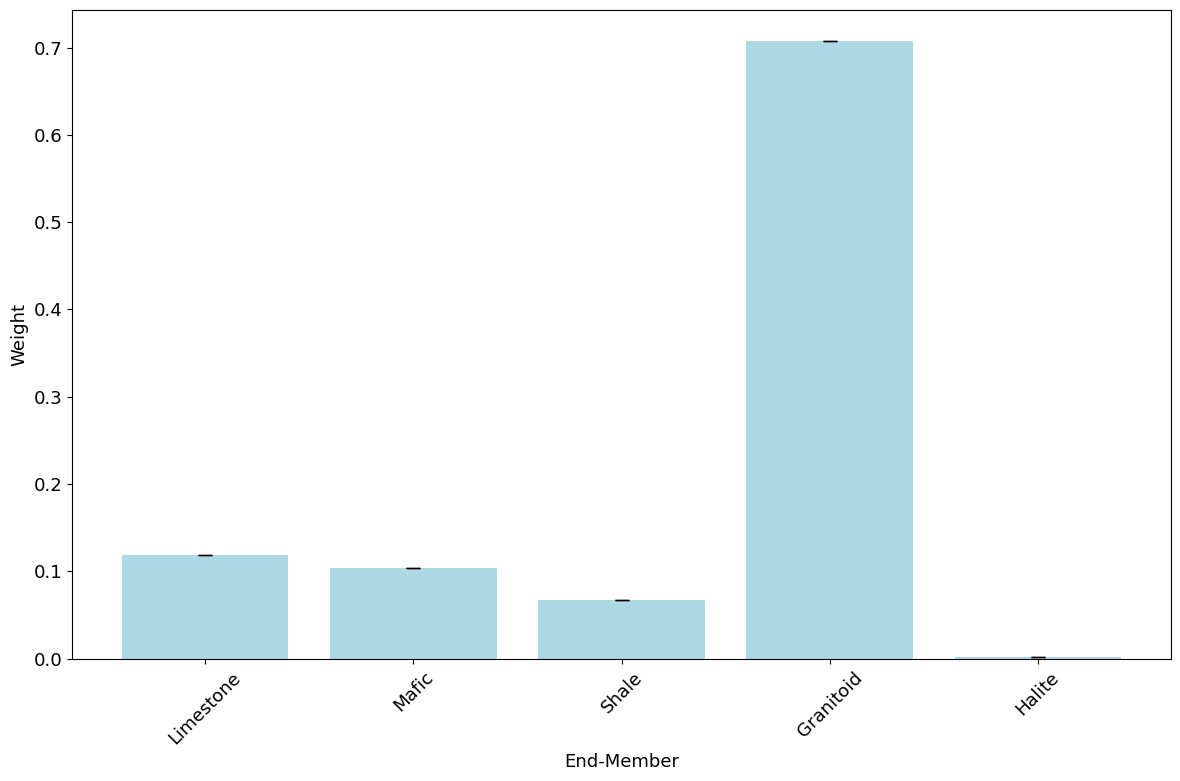

In [861]:

# Assuming final_results is already defined and contains the required data
end_member_keys = [key for key in final_results]  # Extract all end-member keys
weights = [final_results[key]['weight'] for key in end_member_keys]  # Extract weights
uncertainties = [final_results[key]['weight_uncertainty'] for key in end_member_keys]  # Extract uncertainties

# Create a bar plot
plt.figure(figsize=(12, 8))
plt.bar(end_member_keys, weights, color='lightblue', yerr=uncertainties, capsize=5)
plt.xlabel('End-Member')
plt.ylabel('Weight')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [862]:
"""
All chain results
"""
all_chain_results = []
for i in range(n_chains): 
    
    weights = component_mean_weights[i]
    uncertainties = component_mean_uncertainties[i]
    # To store aggregated compositions
    aggregate_data = defaultdict(lambda: {
        'composition': defaultdict(list),
        'weight': 0,
        'weight_uncertainty_squared': 0
    })
    
    # Process data
    for index, comp_dict in enumerate(Compositions[i][-1]):

        for key, comp in comp_dict.items():
            if 'random' in key:
                # Treat random entries uniquely
                suffix = key.split('_')[1] if '_' in key else index
                random_key = f"random_{suffix}"
                aggregate_data[random_key] = {
                    'composition': comp,
                    'weight': weights[index],
                    'weight_uncertainty': uncertainties[index]
                }
            else:
                # Aggregate like entries
                aggregate_data[key]['weight'] += weights[index]
                aggregate_data[key]['weight_uncertainty_squared'] += uncertainties[index]**2
                for compound, value in comp.items():
                    aggregate_data[key]['composition'][compound].append(value)
    
    # Calculate means, std deviations, and total uncertainties
    final_results = {}
    for key, data in aggregate_data.items():
        if 'random' in key:
            final_results[key] = data
        else:
            final_results[key] = {
                'composition': {},
                'weight': data['weight'],
                'weight_uncertainty': np.sqrt(data['weight_uncertainty_squared'])
            }
            for compound, values in data['composition'].items():
                final_results[key]['composition'][compound] = {
                    'mean': np.mean(values),
                    'std': np.std(values)
                }
    all_chain_results.append(final_results)

In [863]:
"""
All chain results
"""
all_chain_results_streamlined = []
for i in range(n_chains): 
    
    weights = component_mean_weights[i]
    uncertainties = component_mean_uncertainties[i]
    # To store aggregated compositions
    aggregate_data = defaultdict(lambda: {
        'composition': defaultdict(list),
        'weight': 0,
        'weight_uncertainty_squared': 0
    })
    
    # Process data
    for index, comp_dict in enumerate(Compositions[i][-1]):

        for key, comp in comp_dict.items():
            # Aggregate like entries
            aggregate_data[key]['weight'] += weights[index]
            aggregate_data[key]['weight_uncertainty_squared'] += uncertainties[index]**2
            for compound, value in comp.items():
                aggregate_data[key]['composition'][compound].append(value)
    
    # Calculate means, std deviations, and total uncertainties
    final_results = {}
    for key, data in aggregate_data.items():

        final_results[key] = {
            'composition': {},
            'weight': data['weight'],
            'weight_uncertainty': np.sqrt(data['weight_uncertainty_squared'])
        }
        for compound, values in data['composition'].items():
            final_results[key]['composition'][compound] = {
                'mean': np.mean(values),
                'std': np.std(values)
            }
    all_chain_results_streamlined.append(final_results)

In [864]:
all_chain_results_streamlined

[{'Limestone': {'composition': {'K$_{2}$O': {'mean': 2.2456212646174515e-11,
     'std': 4.366688840283999e-11},
    'CaO': {'mean': 0.9999999997637362, 'std': 1.4145637298507716e-10},
    'TiO$_{2}$': {'mean': 1.214883954899973e-11,
     'std': 1.2653033796385119e-11},
    'SiO$_{2}$': {'mean': 8.932931149277158e-11, 'std': 7.083010017065097e-11},
    'Al$_{2}$O$_{3}$': {'mean': 1.799035954199734e-11,
     'std': 2.0544453786207493e-11},
    'Na$_{2}$O': {'mean': 3.775249281409958e-12, 'std': 5.46547077532891e-12},
    'MgO': {'mean': 2.75800814118324e-11, 'std': 4.743892868470767e-11},
    'FeO': {'mean': 3.035478019524669e-11, 'std': 2.8055327173590684e-11},
    'MnO': {'mean': 1.032732724873077e-11, 'std': 8.933186726137642e-12},
    'Cl': {'mean': 1.7224274883034072e-11, 'std': 1.1649723746317353e-11},
    'SO$_{3}$': {'mean': 4.89389004078973e-12, 'std': 4.0606257873716665e-12},
    'P$_{2}$O$_{5}$': {'mean': 1.8364848923236045e-13,
     'std': 9.299699962728508e-14}},
   'weight

In [865]:
# Assuming all_chain_results_streamlined is a list of dictionaries
all_keys = set()
for results in all_chain_results_streamlined:
    all_keys.update(results.keys())

# Convert set to a sorted list to maintain consistent order
sorted_keys = sorted(all_keys)

In [866]:
sorted_keys

['Anhydrite', 'Granitoid', 'Halite', 'Limestone', 'Mafic', 'Shale']

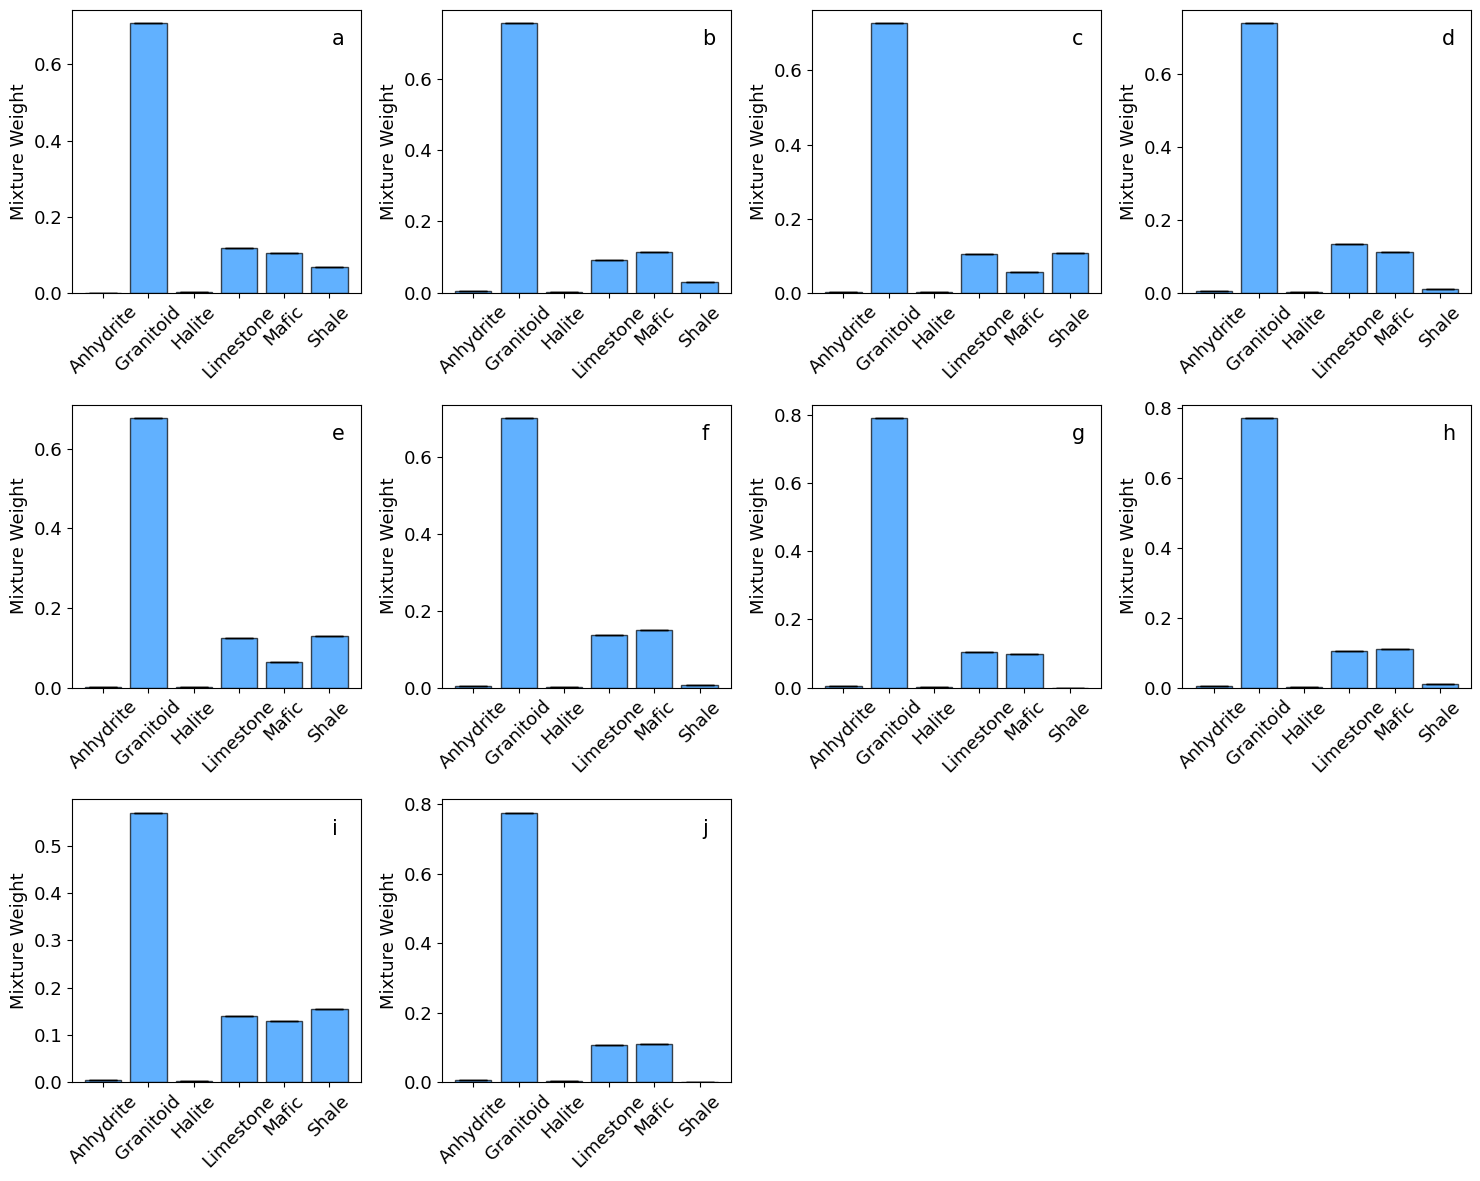

In [941]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(15, 12))
chain_labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', ]
axs = axs.flatten()

# Assuming all_chain_results_streamlined is a list of dictionaries
all_keys = set()
for results in all_chain_results_streamlined:
    all_keys.update(results.keys())

# Convert set to a sorted list to maintain consistent order
sorted_keys = sorted(all_keys)

for i in range(n_chains):
    # Ensure you fetch data for keys in the same order
    weights = [all_chain_results_streamlined[i].get(key, {'weight': 0})['weight'] for key in sorted_keys]
    uncertainties = [all_chain_results_streamlined[i].get(key, {'weight_uncertainty': 0})['weight_uncertainty'] for key in sorted_keys]

    # Plot on the i-th subplot
    axs[i].bar(sorted_keys, weights, yerr=uncertainties, align='center', alpha=0.7, ecolor='black', capsize=10, facecolor='dodgerblue', edgecolor='k')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].set_ylabel('Mixture Weight')
    axs[i].text(0.9, 0.875, chain_labels[i], transform=axs[i].transAxes, fontsize=15)

# Delete the last two axes if they are not used
if n_chains < len(axs):
    for j in range(n_chains, len(axs)):
        fig.delaxes(axs[j])

#axs[3,3].delaxes([])

plt.tight_layout()
plt.savefig('Components_from_chains.png', 
            bbox_inches = 'tight', 
            dpi = 400)

# Results combined

* Combined results, KDE plots for the Harker Diagrams

In [868]:
all_chain_results_streamlined[1];

In [869]:
"""
Get Average compositions 
of the end-members
"""
# Assuming all_chain_results_streamlined is a list of dictionaries like the one shown
component_keys = set(key for chain in all_chain_results_streamlined for key in chain.keys())  # Get all unique components
oxide_keys = {component: set() for component in component_keys}

# Get all unique oxides for each component across all chains
for chain in all_chain_results_streamlined:
    for component in chain:
        if 'composition' in chain[component]:  # Check if 'composition' is a key in the component
            oxide_keys[component].update(chain[component]['composition'].keys())

# Initialize dictionaries to store aggregated data
mean_compositions = {component: {oxide: [] for oxide in oxides} for component, oxides in oxide_keys.items()}
std_compositions = {component: {oxide: [] for oxide in oxides} for component, oxides in oxide_keys.items()}

# Aggregate data from each chain
for chain in all_chain_results_streamlined:
    for component in component_keys:
        if component in chain:  # Check if the component exists in this chain
            for oxide in oxide_keys[component]:
                if oxide in chain[component]['composition']:
                    mean_compositions[component][oxide].append(chain[component]['composition'][oxide]['mean'])
                    std_compositions[component][oxide].append(chain[component]['composition'][oxide]['std'])

# Calculate average means and standard deviations
final_stats = {component: {} for component in component_keys}
for component in component_keys:
    for oxide in oxide_keys[component]:
        if mean_compositions[component][oxide]:  # Check if list is not empty
            final_mean = np.mean(mean_compositions[component][oxide])
            # Weighted standard deviation, assuming variance sum for simplification
            final_std = np.sqrt(np.mean(np.array(std_compositions[component][oxide])**2))
            final_stats[component][oxide] = {'mean': final_mean, 'std': final_std}


In [940]:
print(components)

['Shale', 'Granitoid', 'Anhydrite', 'Halite', 'Limestone', 'Mafic']


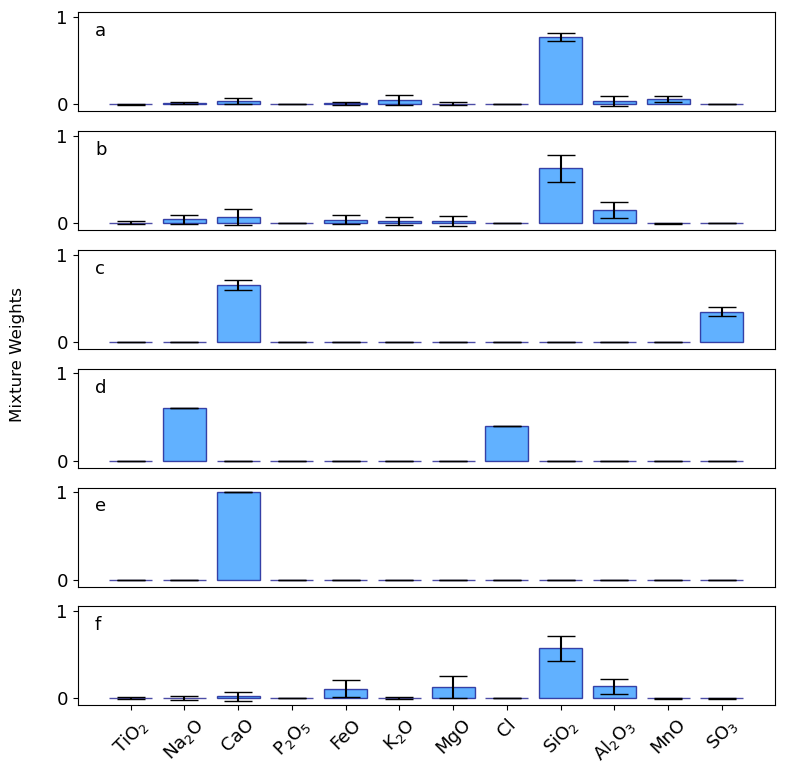

In [939]:
final_stats# Assuming 'final_stats' is your dictionary containing the data
components = list(final_stats.keys())  # List of all components
n_panels = 6  # Number of panels you want

fig, axs = plt.subplots(n_panels,1, figsize=(9, 9), sharey=True)  # Adjust figsize as needed
s_text = ['a' , 'b', 'c', 'd', 'e', 'f']
for i, (ax, component) in enumerate(zip(axs, components[:n_panels])):  # Loop through the first four components
    oxides = list(final_stats[component].keys())
    means = [final_stats[component][oxide]['mean'] for oxide in oxides]
    stds = [final_stats[component][oxide]['std'] for oxide in oxides]

    x_pos = np.arange(len(oxides))  # Create a position for each bar

    # Plot bars
    ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.7, ecolor='black', capsize=10, 
           facecolor = 'dodgerblue', 
          edgecolor = 'navy')
    #ax.set_yticklabels('')
    ax.text(0.025, 0.76, 
            s = s_text[i],
            transform = ax.transAxes)

    # Only add x-tick labels to the bottom subplot
    if i == len(axs) - 1:
        ax.set_xticks(x_pos)
        ax.set_xticklabels(oxides, rotation=45, ha='center')
    else:
        ax.set_xticks([])  # Remove x-tick labels for non-bottom subplots


fig.text(0.05, 0.5, 'Mixture Weights', va='center', rotation='vertical', fontsize=12)

plt.savefig('Average_Composition.png', 
            bbox_inches = 'tight', 
            dpi = 500)

In [871]:
combined_weights = {}

for i in range(n_chains): 
    
    end_member_keys = list(all_chain_results_streamlined[i]) 
    weights = [all_chain_results_streamlined[i][key]['weight'] for key in end_member_keys]  
    uncertainties = [all_chain_results_streamlined[i][key]['weight_uncertainty'] for key in end_member_keys] 

    for key in end_member_keys: 
        if key not in combined_weights:
            combined_weights[key] = []
        combined_weights[key].append(all_chain_results[i][key]['weight'])


    statistics = {}
    for key, weights in combined_weights.items(): 
        component_mean = np.mean(weights)
        component_std = np.std(weights)
        statistics[key] = {"mean_weight": 
                            component_mean, "std_weight" : component_std}
        

In [872]:
"""
Plotting stuff
"""
end_member_keys = list(statistics) # Extract all end-member keys
f_weights = [statistics[key]['mean_weight'] for key in end_member_keys]
f_std = [2*statistics[key]['std_weight'] for key in end_member_keys]

In [873]:
for i in range(len(end_member_keys)): 
    
    print(end_member_keys[i], f_weights[i] *100, f_std[i] * 100)

Limestone 11.639524594288524 3.116246075902779
Mafic 10.502036078890885 5.145704117635915
Shale 6.46108035582852 11.143149983837496
Granitoid 72.11471995558938 12.180540545041314
Halite 0.22863292873424343 0.02634070088985984
Anhydrite 0.38469128648239287 0.18847563812404766


In [874]:
end_member_keys

['Limestone', 'Mafic', 'Shale', 'Granitoid', 'Halite', 'Anhydrite']

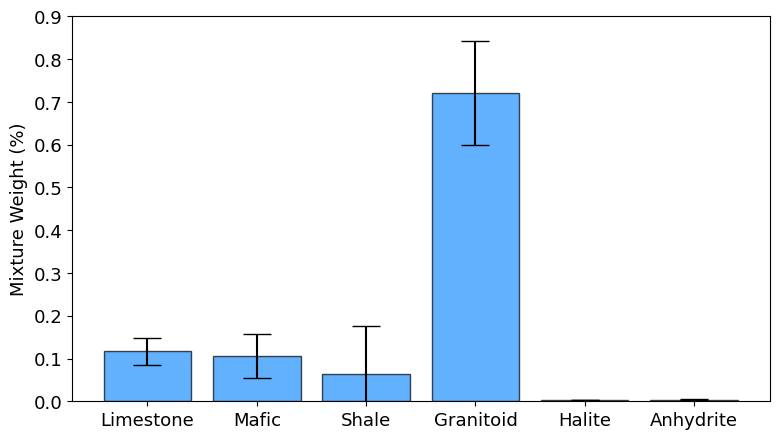

In [876]:
fig, ax = plt.subplots(1, 1, figsize = (9,5))

# Plot on the i-th subplot
end_Members = end_member_keys
ax.bar(end_Members, 
           f_weights, 
           yerr= f_std,
           align='center', 
           alpha=0.7,
           ecolor='black', 
           capsize=10, 
          facecolor = 'dodgerblue', 
          edgecolor = 'k')

ax.set_ylabel('Mixture Weight (%)')
#ax.set_yscale('log')
ax.set_ylim(0, 0.9)
plt.savefig('Combined_components.png', 
            bbox_inches = 'tight', 
            dpi = 400)

In [877]:
# Define feature labels for the y-axis
from scipy.stats import gaussian_kde
feature_labels_y = ['K$_{2}$O', 'CaO', 'TiO$_{2}$', 'SiO$_{2}$',
                    'Al$_{2}$O$_{3}$', 'Na$_{2}$O', 'MgO',
                    'FeO', 'MnO', 'Cl', 'SO$_{3}$', 'P$_{2}$O$_{5}$']
si02_index = 3  # Index for SiO2 in your data arrays, used as the x-axis

all_models_combined = np.concatenate(all_means, axis = 0)

In [878]:
letters = ['A', 'B', 'C', 'D', 'E','F', 'G', 'H', 'I', 'J', 'K', 'L']

In [879]:
letter_index = 0

In [880]:
from matplotlib.colors import Normalize

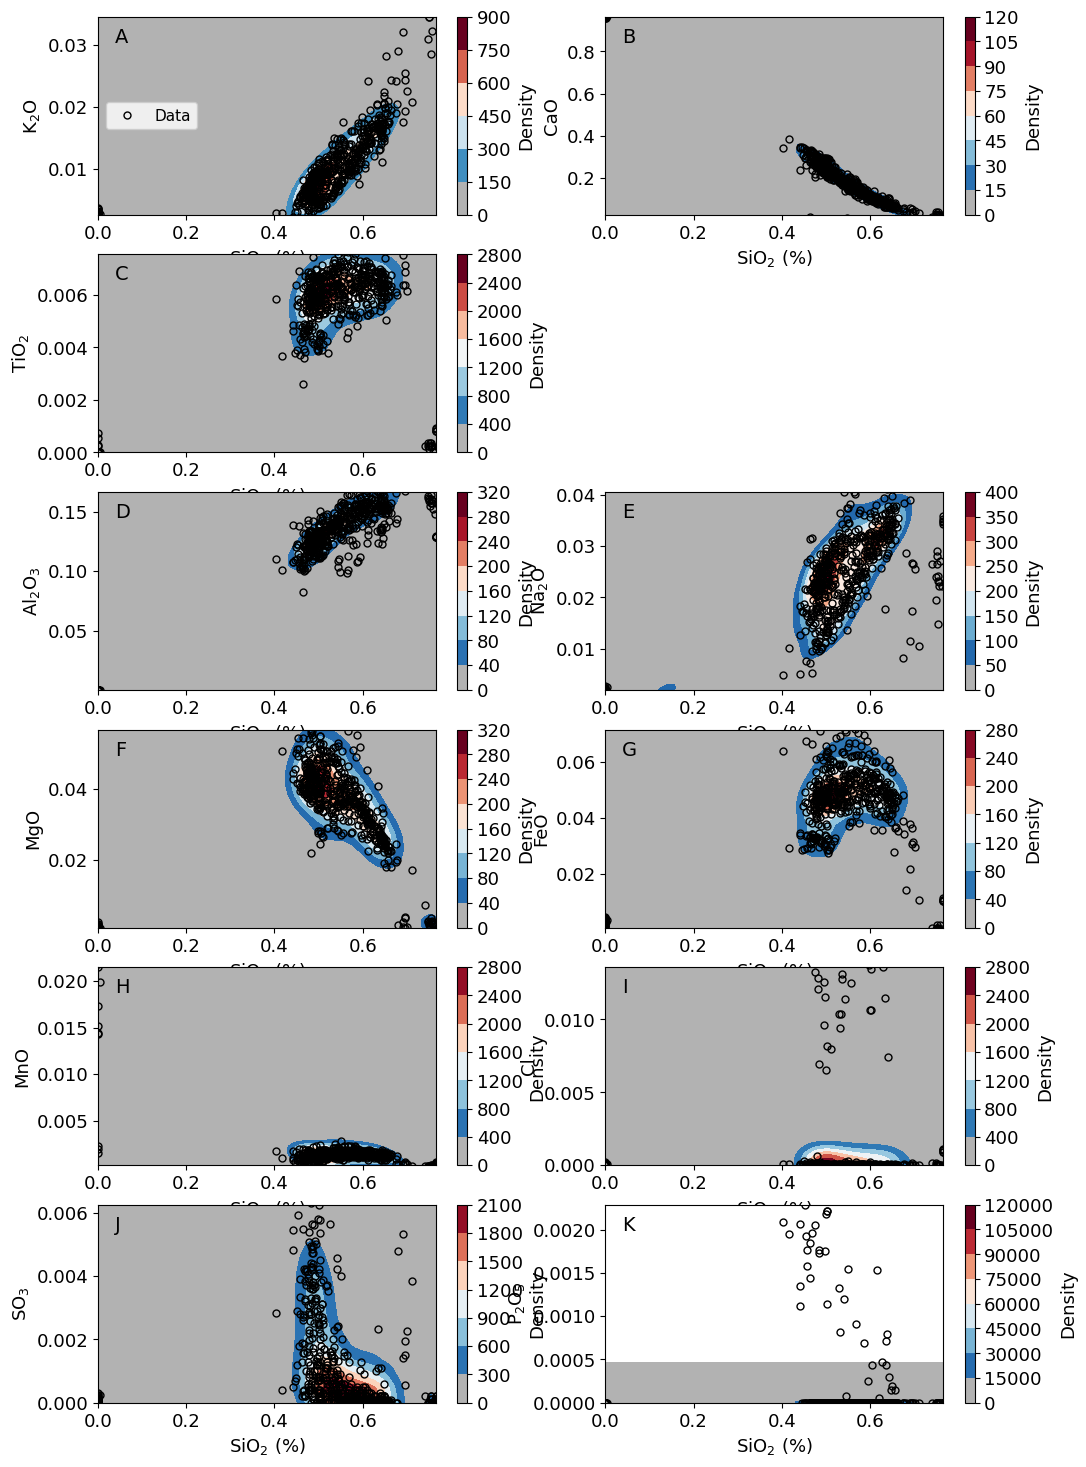

In [881]:
letter_index = 0

fig, axs = plt.subplots(6, 2, figsize=(12, 18))
axs = axs.ravel()

for i, label in enumerate(feature_labels_y):
    ax = axs[i]
    # Skip plotting if the indices are the same
    if i == si02_index:
        ax.axis('off')  # Turn off axis plotting
        continue  # Skip the rest of the loop
    
    si02_data = all_models_combined[:, si02_index]
    test = all_models_combined[:, i]


    # Create a grid of points where we want to evaluate the KDE
    xx, yy = np.mgrid[si02_data.min():si02_data.max():100j, 
                    test.min():test.max():100j]

    positions = np.vstack([xx.ravel(), yy.ravel()])
    kernel = gaussian_kde(np.vstack([si02_data, test]))
    f = np.reshape(kernel(positions).T, xx.shape)
    cmap = plt.get_cmap('RdBu_r').copy()
    cmap.set_under('grey', alpha=0.6)  # Set under-value color to transparent
    norm = Normalize(vmin= 0.1 * f.max(), 
                 vmax=f.max())

    # Plot the 2D KDE using contourf with the custom colormap and normalization
    cf = ax.contourf(xx, yy, f, 
                     cmap=cmap, norm = norm)
        
    cbar = plt.colorbar(cf, ax=ax, 
                       label = 'Density')

    # Plotting the data points
    ax.plot(Clean_Data[:, si02_index],
            Clean_Data[:, i], 'o',
            alpha = 1, 
            markerfacecolor = "None", 
            markersize = 5, 
            markeredgecolor='k',
            markeredgewidth = 1,
            label='Data' if i == 0 else "")
    
    if i == 0:
        ax.legend(fontsize=11,
                  loc=6, 
                  ncol = 2)

    ax.set_xlabel('SiO$_{2}$ (%)')
    ax.set_ylabel(label)
    
    ax.set_xlim(Clean_Data[:, si02_index].min(), 
                Clean_Data[:, si02_index].max())
    
    ax.set_ylim(np.percentile(Clean_Data[:,i], 2.5), 
                np.percentile(Clean_Data[:,i], 97.5))


    ax.text(0.05, 0.87, s=letters[letter_index], 
            transform=ax.transAxes,  fontsize=14)
    
    letter_index += 1  # Increment letter index only when a plot is made

# If the number of plots does not fill the last row, turn off the remaining axes
for ax in axs[len(feature_labels_y):]:
    ax.axis('off')


#plt.tight_layout()
plt.savefig('Figure_8_Impact_glass_model_result_27.pdf', 
           dpi = 300, 
           bbox_inches = 'tight')

# Volatile Budget Estimation 

In [882]:
"""
Plotting stuff
"""
end_member_keys = list(statistics) # Extract all end-member keys
f_weights = [statistics[key]['mean_weight'] for key in end_member_keys]
f_std = [statistics[key]['std_weight'] for key in end_member_keys]

In [883]:
statistics

{'Limestone': {'mean_weight': 0.11639524594288524,
  'std_weight': 0.015581230379513896},
 'Mafic': {'mean_weight': 0.10502036078890886,
  'std_weight': 0.025728520588179572},
 'Shale': {'mean_weight': 0.0646108035582852,
  'std_weight': 0.055715749919187485},
 'Granitoid': {'mean_weight': 0.7211471995558938,
  'std_weight': 0.06090270272520657},
 'Halite': {'mean_weight': 0.0022863292873424343,
  'std_weight': 0.0001317035044492992},
 'Anhydrite': {'mean_weight': 0.0038469128648239287,
  'std_weight': 0.0009423781906202382}}

In [970]:
"""
Chixichlub impact 
 - 10x10^15 kg or one trillion metric tons

Volume of ejected Sulphur 
- Model estimate times this value
"""
mass_ejected_a = 1.18467e17
std_mass_ejected_a = 6e16
N_ = 100000

CO2_EJECTED = np.zeros(N_)
S_EJECTED = np.zeros(N_)
H20_EJECTED = np.zeros(N_)

for i in range(N_): 

    anhydrite_component_weight_mc = np.random.normal(statistics['Anhydrite']['mean_weight'], 
                                              statistics['Anhydrite']['std_weight'])
    
    limestone_component_weight_mc = np.random.normal(statistics['Limestone']['mean_weight'], 
                                              statistics['Limestone']['std_weight'])

    granitoid_component_weight_mc = np.random.normal(statistics['Granitoid']['mean_weight'], 
                                              statistics['Granitoid']['std_weight'])

  
    mass_ejected_mc = np.random.normal(mass_ejected_a, mass_ejected_a/10) #Artemieva with 10% unceratinty

    Carbon_dioxide_budget = np.random.normal(0.4397, 0.04397) # From webmineral assume 10% variation


    Sulfur_anhydrite_budget = np.random.normal(0.2355, 0.02355) # From webmineral assume 10% variation


    water_content_granitoid = np.random.normal(0.03, 0.003) # From webmineral assume 10% variation

    water_content_shale = np.random.normal(0.005, 0.0005) # From webmineral assume 10% variation


    Sulfer = (Sulfur_anhydrite_budget * anhydrite_component_weight_mc)

    CO_2 = limestone_component_weight_mc * Carbon_dioxide_budget

    H20 = water_content_granitoid * water_content_granitoid 

    S_EJECTED[i] = Sulfer * mass_ejected_mc
    CO2_EJECTED[i] = CO_2 * mass_ejected_mc
    H20_EJECTED[i] = H20 * mass_ejected_mc


In [971]:
print('Sulfur', S_EJECTED.mean(axis = 0)/1000000000000, 
      S_EJECTED.std(axis = 0)/1000000000000, 'Gt')
print('CO$_{2}$', CO2_EJECTED.mean(axis = 0)/1000000000000, 
      CO2_EJECTED.std(axis = 0)/1000000000000, 'Gt')
print('H$_{2}$O', H20_EJECTED.mean(axis = 0)/1000000000000, 
      H20_EJECTED.std(axis = 0)/1000000000000, 'Gt')

Sulfur 107.28397835902425 30.672085724041292 Gt
CO$_{2}$ 6062.833074714685 1183.2711682006977 Gt
H$_{2}$O 107.58647589801153 24.057379162038895 Gt


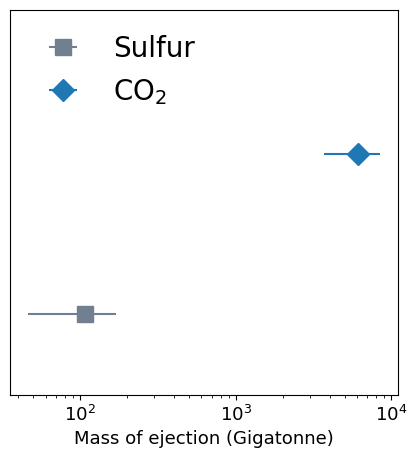

In [972]:
fig, ax = plt.subplots(1, 1, figsize = (5,5))

ax.errorbar(x = S_EJECTED.mean(axis = 0)/1000000000000, 
            xerr =  2* S_EJECTED.std(axis = 0)/1000000000000, 
            y = 1,
           color = 'slategrey', 
           label = 'Sulfur', barsabove = True, 
           fmt= 's', markersize= 11)


ax.errorbar(x = CO2_EJECTED.mean(axis = 0)/1000000000000, 
            xerr = 2 * CO2_EJECTED.std(axis = 0)/1000000000000, 
            y = 2,
           label = 'CO$_{2}$', barsabove = True, 
           fmt= 'D', markersize= 11)

ax.set_xlabel('Mass of ejection (Gigatonne)')
ax.set_yticks([])
ax.set_ylim(0.5, 2.9)
ax.set_xscale('log')

ax.legend(fontsize = 20, frameon = False, 
          loc = 2)



In [973]:
# Calculate mean and standard deviation in Gigatonnes (Gt)
s_mean = S_EJECTED.mean(axis=0) / 1e12
s_err = S_EJECTED.std(axis=0) / 1e12
co2_mean = CO2_EJECTED.mean(axis=0) / 1e12
co2_err = CO2_EJECTED.std(axis=0) / 1e12
h2o_mean = H20_EJECTED.mean(axis=0) / 1e12
h2o_err = H20_EJECTED.std(axis=0) / 1e12

In [966]:
s_mean

107.20559769122912

In [967]:
sig_1992_err_s = np.array([3800, 13000])
sig_1992_err_co2 = np.array([1e4, 2e5])

pierzazzo_1998_err_s = np.array([40, 560])
pierzazzo_1998_err_co2 = np.array([350, 3500])
pierzazzo_1998_err_h20= np.array([462, 1553])

art_2017_err_s = np.array([325, 130])
art_2017_err_co2 = np.array([425, 160])

pope_1997_err_s = np.array([326, 527])
pope_1997_err_co2 = np.array([525, 927])
pope_1997_err_h20 = np.array([225, 767])

pope_1997_err_s = np.array([326, 527])
pope_1997_err_co2 = np.array([525, 927])
pope_1997_err_h20 = np.array([225, 767])

In [968]:
# Mean values for s and CO2
means_s = [np.mean(sig_1992_err_s), np.mean(pierzazzo_1998_err_s),
           art_2017_err_s[0], np.mean(pope_1997_err_s)]
means_co2 = [np.mean(sig_1992_err_co2), np.mean(pierzazzo_1998_err_co2), 
             art_2017_err_co2[0], np.mean(pope_1997_err_co2)]

# Error values for s and CO2 (symmetric around the mean)
errors_s = [np.ptp(sig_1992_err_s)/2, np.ptp(pierzazzo_1998_err_s)/2, 
            art_2017_err_s[1], np.ptp(pope_1997_err_s )/2]
errors_co2 = [np.ptp(sig_1992_err_co2)/2, np.ptp(pierzazzo_1998_err_co2)/2, 
              art_2017_err_co2[1], np.ptp(pope_1997_err_co2 )/2]

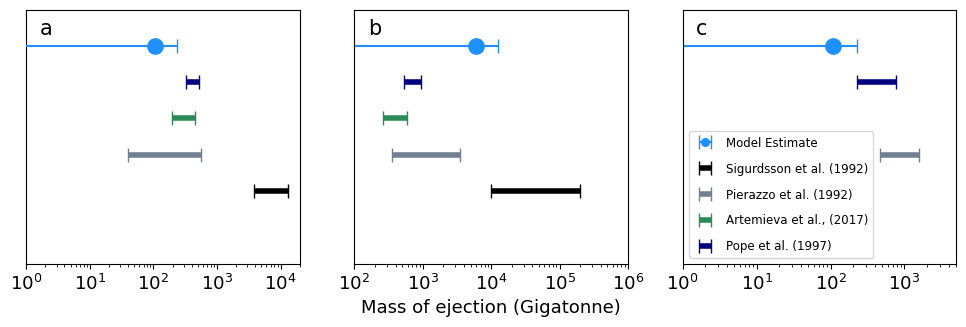

In [969]:
fig, ax = plt.subplots(1,3, figsize = (12, 3.3))

# Error bars for Sulfur on the left plot
ax[0].errorbar(x=s_mean, xerr= 2 * s_err, 
               y=4, color='dodgerblue', 
               label='Model Estimate',fmt='o', markersize=11, 
              capsize = 5,
              zorder= 31)



studies = ['Sigurdsson et al. (1992)', 
           'Pierazzo et al. (1992)', 
           'Artemieva et al., (2017)',
           'Pope et al. (1997)']

colors_s = ['k', 'slategrey', 'seagreen', 'navy']
for i in range(4): 

    ax[0].errorbar(y = i, x = means_s[i], 
               xerr=errors_s[i], fmt='none', ecolor=colors_s[i], label=studies[i],
                   lw = 4,capsize=5, 
                  barsabove = True, zorder = 3)


ax[0].set_xscale('log')
ax[0].set_ylim(-2, 5)



# Error bars for CO2 on the right plot
ax[1].errorbar(x=co2_mean, xerr= 2*co2_err, y=4, 
             capsize = 5, color='dodgerblue',
             fmt='o', markersize=11)



for i in range(4): 

    ax[1].errorbar(y = i, x = means_co2[i], 
               xerr=errors_co2[i], fmt='none', ecolor=colors_s[i], label=studies[i],
                   lw = 4,capsize=5, 
                  barsabove = True, zorder = 3)

ax[1].set_ylim(-2, 5)


ax[0].set_yticks([])
ax[1].set_yticks([])
ax[2].set_yticks([])

ax[0].text(0.05, 0.9, 
           s = 'a',
           fontweight = 'normal',
           fontsize = 15, 
          transform = ax[0].transAxes)

ax[1].text(0.05, 0.9, 
           s = 'b',
           fontweight = 'normal',
           fontsize = 15, 
          transform = ax[1].transAxes)

ax[2].text(0.05, 0.9, 
           s = 'c',
           fontweight = 'normal',
           fontsize = 15, 
          transform = ax[2].transAxes)



# Error bars for CO2 on the right plot
ax[2].errorbar(x=h2o_mean, xerr= 2*h2o_err, y=4, 
             capsize = 5, color='dodgerblue',
             fmt='o', markersize=11)


# Error bars for CO2 on the right plot
ax[2].errorbar(x=np.mean(pope_1997_err_h20), xerr= np.ptp(pope_1997_err_h20)/2, y=3, 
             capsize = 5, fmt='none', ecolor='navy', 
                   lw = 4,
                  barsabove = True, zorder = 3)

# Error bars for CO2 on the right plot
ax[2].errorbar(x=np.mean(pierzazzo_1998_err_h20), xerr= np.ptp(pierzazzo_1998_err_h20)/2, y=1, 
             capsize = 5, fmt='none', ecolor='slategrey', 
                   lw = 4,
                  barsabove = True, zorder = 2)

# Set the xlabel and ticks
ax[1].set_xlabel('Mass of ejection (Gigatonne)')


ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[0].set_xlim(1, 2e4)
ax[1].set_xlim(10, 4e5)
ax[1].set_xlim(100, 1e6)
ax[2].set_xlim(1, 5e3)
ax[2].set_ylim(-2, 5)


handles, labels = ax[0].get_legend_handles_labels()

ax[2].legend(handles, labels, loc=3, 
            fontsize= 8.5, markerscale = 0.5, labelspacing = 1.1)

#plt.tight_layout()
plt.savefig('Volatile_budget_Figure10.png', 
           bbox_inches ='tight', dpi = 300)

# OUTPUT PLOT
---------

In [892]:
Clean_Data = MT_data_initialize.Unpack_Data_and_Features()
Data_Features = MT_data_initialize.Data_Features

mt_df = MT_data_initialize.load_data()

In [893]:
from matplotlib.ticker import MaxNLocator

In [898]:
si02_index

3

In [922]:
xx_dict = {}
yy_dict = {}
f_dict_z = {}

for i in range(12):
    si02_data = all_models_combined[:, si02_index]
    test = all_models_combined[:, i]

    if i ==3: 
        test = all_models_combined[:, i-1]
        # Create a grid of points where we want to evaluate the KDE
        xx, yy = np.mgrid[si02_data.min():si02_data.max():100j, 
                    test.min():test.max():100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        kernel = gaussian_kde(np.vstack([si02_data, test]))
        f = np.reshape(kernel(positions).T, xx.shape)

    else:
        # Create a grid of points where we want to evaluate the KDE
        xx, yy = np.mgrid[si02_data.min():si02_data.max():100j, 
                        test.min():test.max():100j]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        kernel = gaussian_kde(np.vstack([si02_data, test]))
        f = np.reshape(kernel(positions).T, xx.shape)
        xx_dict[i] = xx
        yy_dict[i] = yy
        f_dict_z[i] = f*100

In [926]:
f_dict = {}
for i in range(12): 
    if i ==3: 
        continue
    f_dict[i] =  f_dict_z[i]/f_dict_z[i].max()
    

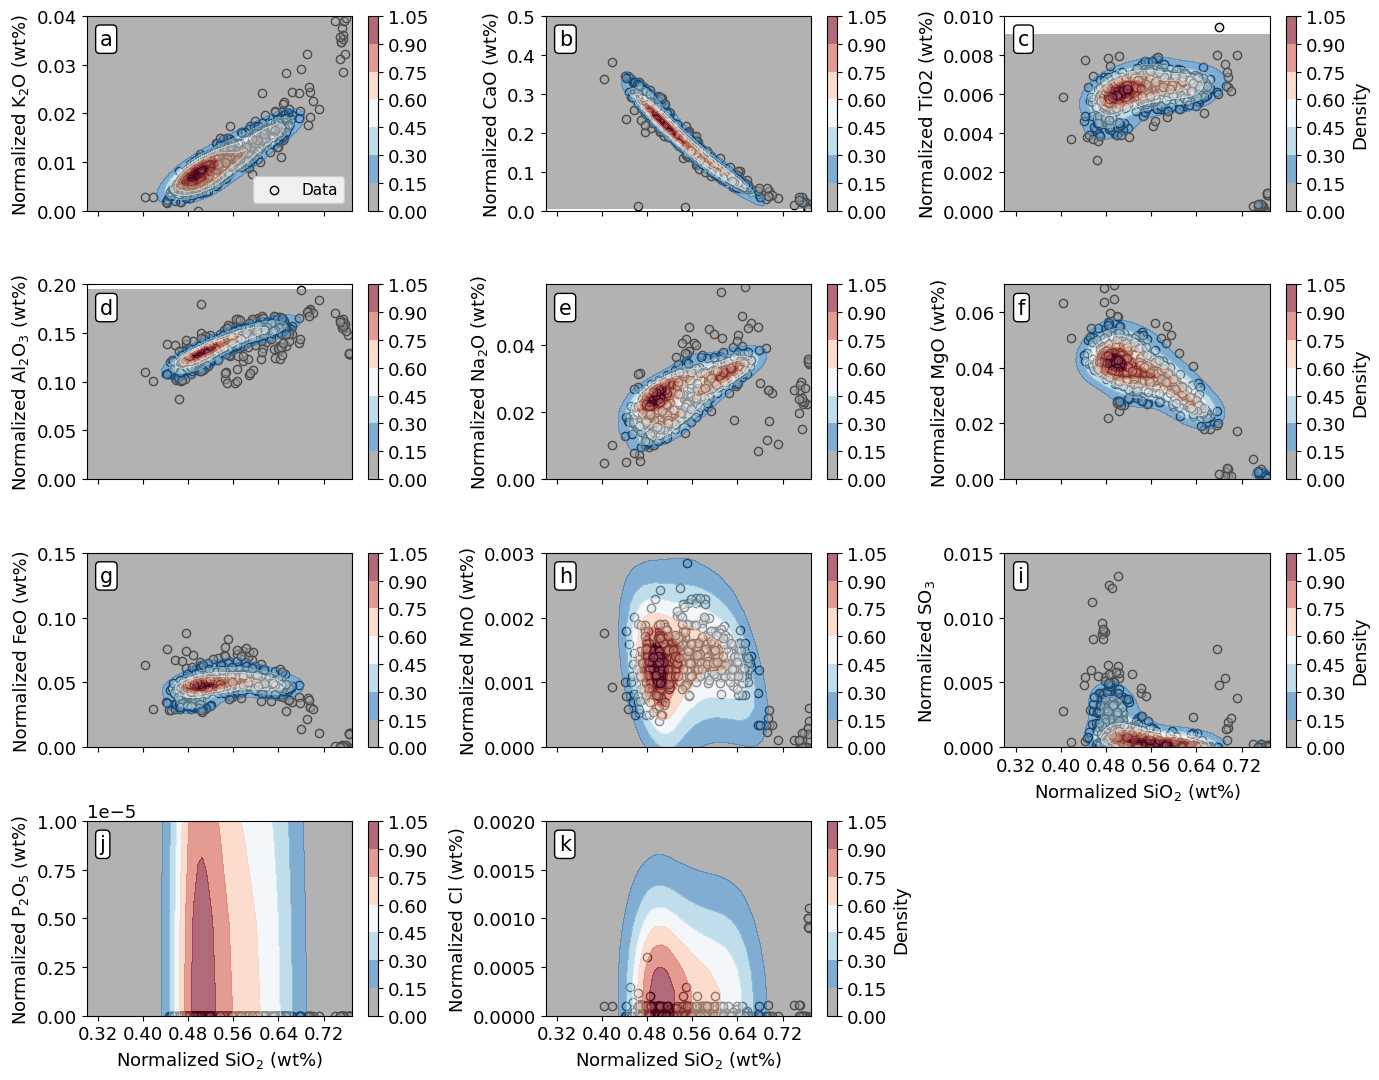

In [927]:
fig, ax = plt.subplots(4,3, figsize = (14, 11))


ax[0,0].scatter(Clean_Data[:,3], 
        Clean_Data[:,0], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.2), 
               zorder= 0, 
               label = 'Data')


#ax[0,0].set_xlabel('SiO$_{2}$ (wt%)')

ax[0,0].set_xticklabels('')
ax[0,0].set_ylabel('Normalized K$_{2}$O (wt%)')



ax[0,1].scatter(Clean_Data[:,3], 
        Clean_Data[:,1], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.5))


ax[0,1].set_xticklabels('')
ax[0,1].set_ylabel('Normalized CaO (wt%)')

ax[0,2].scatter(Clean_Data[:,3], 
        Clean_Data[:,2], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.5))


ax[0,2].set_xticklabels('')
ax[0,2].set_ylabel('Normalized TiO${2}$ (wt%)')


ax[1,0].scatter(Clean_Data[:,3], 
        Clean_Data[:,4], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.5))

ax[1,0].set_xticklabels('')
ax[1,0].set_ylabel('Normalized Al$_{2}$O$_{3}$ (wt%)')



ax[1,1].scatter(Clean_Data[:,3], 
        Clean_Data[:,5], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.5))



ax[1,1].set_xticklabels('')
ax[1,1].set_ylabel('Normalized Na$_{2}$O (wt%)')


ax[1,2].scatter(Clean_Data[:,3], 
        Clean_Data[:,6], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.5))


ax[1,2].set_xticklabels('')
ax[1,2].set_ylabel('Normalized MgO (wt%)')

ax[2,0].scatter(Clean_Data[:,3], 
        Clean_Data[:,7], 
            marker = 'o', 
                edgecolors=(0, 0, 0,1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.5))

ax[2,0].set_xticklabels('')
ax[2,0].set_ylabel('Normalized FeO (wt%)')


ax[2,1].scatter(Clean_Data[:,3], 
        Clean_Data[:,8], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.5), 
               label = 'Data')


ax[2,1].set_xticklabels('')
ax[2,1].set_ylabel('Normalized MnO (wt%)')


ax[2,2].scatter(Clean_Data[:,3], 
        Clean_Data[:,10], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.4))

ax[2,2].set_xlabel('Normalized SiO$_{2}$ (wt%)')
ax[2,2].set_ylabel('Normalized SO$_{3}$')


ax[3,0].scatter(Clean_Data[:,3], 
        Clean_Data[:,11], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.4))


ax[3,0].set_xlabel('Normalized SiO$_{2}$ (wt%)')
ax[3,0].set_ylabel('Normalized P$_{2}$O$_{5}$ (wt%)')

ax[3,1].scatter(Clean_Data[:,3], 
        Clean_Data[:,9], 
            marker = 'o', 
                edgecolors=(0, 0, 0, 1),  # RGBA for black with alpha=1
                facecolors=(0.83, 0.83, 0.83, 0.4))


ax[3,1].set_xlabel('Normalized SiO$_{2}$ (wt%)')
ax[3,1].set_ylabel('Normalized Cl (wt%)')




cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[0].max(), 
             vmax=f_dict[0].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[0,0].contourf(xx_dict[0], yy_dict[0], f_dict[0], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[0,0])



cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[1].max(), 
             vmax=f_dict[1].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[0,1].contourf(xx_dict[1], yy_dict[1], f_dict[1], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[0,1])



cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[2].max(), 
             vmax=f_dict[2].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[0,2].contourf(xx_dict[2], yy_dict[2], f_dict[2], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[0,2], 
                   label = 'Density')



cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[4].max(), 
             vmax=f_dict[4].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[1,0].contourf(xx_dict[4], yy_dict[4], f_dict[4], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[1,0])



cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[5].max(), 
             vmax=f_dict[5].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[1,1].contourf(xx_dict[5], yy_dict[5], f_dict[5], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[1,1])


cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[6].max(), 
             vmax=f_dict[6].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[1,2].contourf(xx_dict[6], yy_dict[6], f_dict[6], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[1,2], 
                   label = 'Density')


cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[7].max(), 
             vmax=f_dict[7].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[2,0].contourf(xx_dict[7], yy_dict[7], f_dict[7], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[2,0])



cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[8].max(), 
             vmax=f_dict[8].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[2,1].contourf(xx_dict[8], yy_dict[8], f_dict[8], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[2,1])


cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[10].max(), 
             vmax=f_dict[10].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[2,2].contourf(xx_dict[10], yy_dict[10], f_dict[10], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[2,2], 
                   label = 'Density')


cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[11].max(), 
             vmax=f_dict[11].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[3,0].contourf(xx_dict[11], yy_dict[11], f_dict[11], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[3,0])



cmap = plt.get_cmap('RdBu_r').copy()
cmap.set_under('grey', alpha=1)  # Set under-value color to transparent
norm = Normalize(vmin= 0.1 * f_dict[9].max(), 
             vmax=f_dict[9].max())
# Plot the 2D KDE using contourf with the custom colormap and normalization
cf = ax[3,1].contourf(xx_dict[9], yy_dict[9], f_dict[9], 
                 cmap=cmap, norm = norm, 
                     alpha = 0.6)
    
cbar = plt.colorbar(cf, ax=ax[3,1], 
                   label = 'Density')


ax[0,0].xaxis.set_major_locator(MaxNLocator(6))
ax[0,1].xaxis.set_major_locator(MaxNLocator(6))
ax[0,2].xaxis.set_major_locator(MaxNLocator(6))
ax[1,0].xaxis.set_major_locator(MaxNLocator(6))
ax[1,1].xaxis.set_major_locator(MaxNLocator(6))
ax[1,2].xaxis.set_major_locator(MaxNLocator(6))
ax[2,0].xaxis.set_major_locator(MaxNLocator(6))
ax[2,1].xaxis.set_major_locator(MaxNLocator(6))
ax[2,2].xaxis.set_major_locator(MaxNLocator(6))
ax[3,0].xaxis.set_major_locator(MaxNLocator(6))
ax[3,1].xaxis.set_major_locator(MaxNLocator(6))


# Define the letters to use in the plots
letters = 'abcdefghijk' 

# Loop through the rows and columns
for i in range(4):        # Assuming 4 rows
    for j in range(3):    # Assuming 3 columns
        index = i * 3 + j # Calculate the index based on row and column
        if index < len(letters):  # Check if the index is within the length of the letters
            ax[i, j].text(0.05, 0.85, letters[index], 
                          transform=ax[i, j].transAxes, fontsize=15, 
                          bbox=dict(facecolor='white', edgecolor='black',
                                    boxstyle='round,pad=0.2'))


fig.delaxes(ax[3,2])

x_min, x_max = 0.3, 0.77

ymax_index = np.array([0.04, 
                0.5, 0.01, 
                0.2, 0.058, 0.07, 
                0.15, 0.003, 
                0.015, 
                0.00001, 
                0.002, 0.01])

for i in range(4):        # Loop through rows
    for j in range(3):    # Loop through columns
        index = i * 3 + j # Calculate index based on row and column
        if index < Clean_Data.shape[1]:  # Ensure the index is within the range of columns in Clean_Data
            # Set x-axis limits for all plots
            ax[i, j].set_xlim(x_min, x_max)
            
            # Calculate the 5th and 95th percentiles for the y-axis
            y_min = 0
            y_max = ymax_index[index]
            #
            ## Set y-axis limits using these percentiles
            ax[i, j].set_ylim(y_min, y_max)

ax[0,0].legend(fontsize = 11, 
              loc = 4)



plt.tight_layout()
plt.savefig('Model_KDE_outputs.png', 
            dpi = 400, 
            bbox_inches = 'tight')

In [928]:
Clean_data.shape

NameError: name 'Clean_data' is not defined